In [40]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [41]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [42]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

,open,high,low,close,volume
date,,,,,
2022-06-28 20:00:00,256.7800,256.7800,256.6400,256.6400,1143.0
2022-06-28 19:45:00,256.6000,256.6800,256.5500,256.6800,1075.0
2022-06-28 19:30:00,256.5100,256.5100,256.5100,256.5100,329.0
2022-06-28 19:15:00,256.7000,256.7500,256.5500,256.5500,2172.0
2022-06-28 19:00:00,256.5500,256.9900,256.5500,256.9900,1910.0
...,...,...,...,...,...
2022-05-17 05:15:00,265.4622,265.5321,265.2827,265.5321,2014.0
2022-05-17 05:00:00,265.8513,266.3301,265.7515,265.8513,3501.0
2022-05-17 04:45:00,264.8936,265.8513,264.7739,265.8413,14210.0


# INDICATORS CALCULATION

In [43]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [44]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

,ROC
date,
2022-05-17 09:15:00,0.1471
2022-05-17 09:30:00,0.2411
2022-05-17 09:45:00,0.2695
2022-05-17 10:00:00,-0.2889
2022-05-17 10:15:00,-0.4114
...,...
2022-06-28 19:00:00,-0.7320
2022-06-28 19:15:00,-0.6412
2022-06-28 19:30:00,-0.4579


## 2. Simple Moving Average (SMA)

In [45]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

,SMA
date,
2022-05-17 09:00:00,265.3241
2022-05-17 09:15:00,265.3435
2022-05-17 09:30:00,265.3754
2022-05-17 09:45:00,265.4113
2022-05-17 10:00:00,265.3729
...,...
2022-06-28 19:00:00,256.8618
2022-06-28 19:15:00,256.7790
2022-06-28 19:30:00,256.7200


## 3. Relative Strength Index (RSI)

In [46]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

,RSI
date,
2022-05-17 09:15:00,52.5358
2022-05-17 09:30:00,56.1381
2022-05-17 09:45:00,61.5999
2022-05-17 10:00:00,52.1421
2022-05-17 10:15:00,48.7072
...,...
2022-06-28 19:00:00,33.0968
2022-06-28 19:15:00,30.5406
2022-06-28 19:30:00,30.3166


## 4. Bolling Bands (BBANDS)

In [47]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [48]:
# indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
# indicator_bb = indicator_bb[0]
# indicator_bb

**Merge indicators to data**

In [49]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,,
2022-05-17 09:15:00,264.6941,265.0532,264.3649,264.8936,38171.0,0.1471,265.3435,52.5358,265.3435,263.468569,267.218431
2022-05-17 09:30:00,264.7540,265.7415,264.2651,265.4922,64319.0,0.2411,265.3754,56.1381,265.3754,263.481323,267.269477
2022-05-17 09:45:00,265.4622,266.8788,264.8038,266.5578,2397104.0,0.2695,265.4113,61.5999,265.4113,263.461113,267.361487
2022-05-17 10:00:00,266.5454,267.6768,264.8238,265.0832,1711465.0,-0.2889,265.3729,52.1421,265.3729,263.634890,267.110910
2022-05-17 10:15:00,265.1231,265.7315,263.9633,264.4397,1220319.0,-0.4114,265.3182,48.7072,265.3182,263.724725,266.911675
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-28 14:15:00,258.9000,259.4200,258.0303,258.2055,551375.0,-2.7071,260.6285,26.6859,260.6285,259.572880,261.684120
2022-06-28 14:30:00,258.2100,258.2400,257.6400,257.6900,516855.0,-2.3569,260.3175,25.1375,260.3175,259.591047,261.043953
2022-06-28 14:45:00,257.6800,257.7260,256.8900,257.1700,626414.0,-3.0352,259.9150,23.6787,259.9150,259.366933,260.463067


# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [50]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[264.8936],
       [265.4922],
       [266.5578],
       ...,
       [257.17  ],
       [257.47  ],
       [256.85  ]])

In [51]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.64992519],
       [0.66682287],
       [0.69690332],
       ...,
       [0.43189838],
       [0.44036697],
       [0.42286521]])

In [52]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1701
1701


In [53]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1361, 60, 1)
Size validate:  (170, 60, 1)
Size test:  (170, 60, 1)


### b. Train Model

In [54]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
43/43 [==============================] - 12s 109ms/step - loss: 0.0272 - val_loss: 0.0025
Epoch 2/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 6/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 1

### c. Test Model

In [55]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [56]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

6/6 [==============================] - 2s 17ms/step


In [57]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1591,2022-06-23 18:15:00,258.200,258.350,258.2000,258.2000,1608.0,0.8082,257.8890,57.5303,257.8890,254.621742,261.156258,257.910767
1592,2022-06-23 18:30:00,258.350,258.400,258.3000,258.4000,3827.0,0.8823,258.0020,58.6800,258.0020,254.954994,261.049006,257.918640
1593,2022-06-23 18:45:00,258.230,258.490,258.2300,258.4900,2258.0,0.9529,258.1240,59.2031,258.1240,255.334938,260.913062,257.995178
1594,2022-06-23 19:00:00,258.590,258.600,258.5700,258.5700,818.0,0.6030,258.2015,59.6807,258.2015,255.722034,260.680966,258.112274
1595,2022-06-23 19:45:00,258.770,258.790,258.4201,258.7800,1756.0,0.6104,258.2800,60.9441,258.2800,256.149311,260.410689,258.245514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,2022-06-28 14:15:00,258.900,259.420,258.0303,258.2055,551375.0,-2.7071,260.6285,26.6859,260.6285,259.572880,261.684120,258.819092
1757,2022-06-28 14:30:00,258.210,258.240,257.6400,257.6900,516855.0,-2.3569,260.3175,25.1375,260.3175,259.591047,261.043953,258.724854
1758,2022-06-28 14:45:00,257.680,257.726,256.8900,257.1700,626414.0,-3.0352,259.9150,23.6787,259.9150,259.366933,260.463067,258.439270
1759,2022-06-28 15:00:00,257.170,257.760,257.1300,257.4700,531378.0,-2.2142,259.6235,26.2769,259.6235,259.130109,260.116891,257.997070


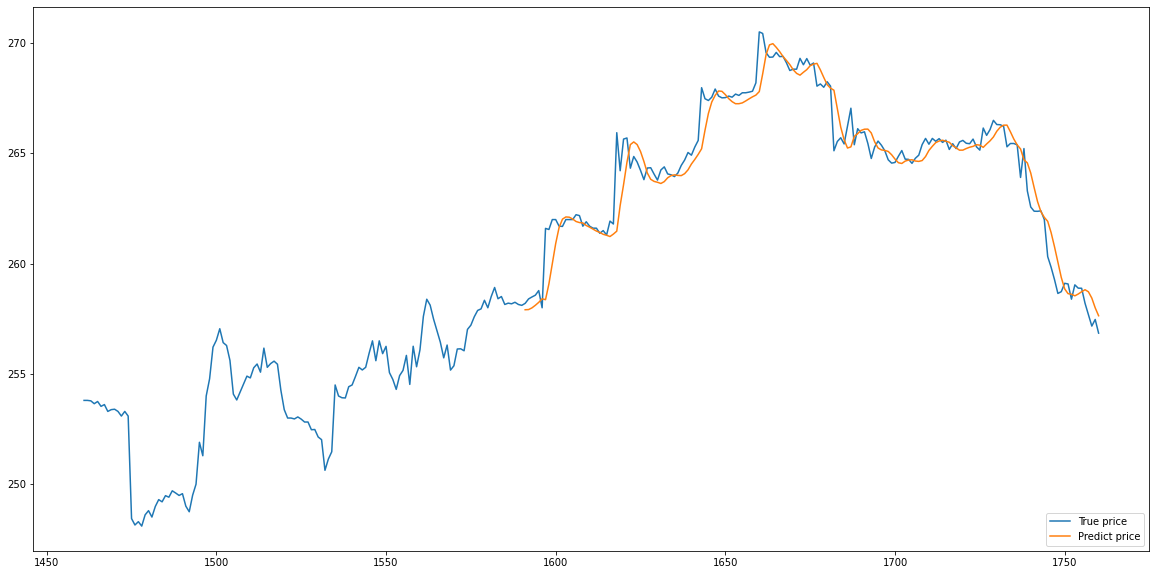

In [58]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [59]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.648936e+02,  1.471000e-01],
       [ 2.654922e+02,  2.411000e-01],
       [ 2.665578e+02,  2.695000e-01],
       ...,
       [ 2.571700e+02, -3.035200e+00],
       [ 2.574700e+02, -2.214200e+00],
       [ 2.568500e+02, -2.178500e+00]])

In [60]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.64992519, 0.57876809],
       [0.66682287, 0.59080548],
       [0.69690332, 0.59444231],
       ...,
       [0.43189838, 0.17125112],
       [0.44036697, 0.27638622],
       [0.42286521, 0.28095787]])

In [61]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1701
1701


In [62]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1361, 60, 2)
Size validate:  (170, 60, 2)
Size test:  (170, 60, 2)


In [63]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
43/43 [==============================] - 8s 88ms/step - loss: 0.0271 - val_loss: 0.0022
Epoch 2/20
43/43 [==============================] - 3s 70ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/20
43/43 [==============================] - 3s 71ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/

In [64]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [65]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

6/6 [==============================] - 2s 17ms/step


array([258.7184 , 258.54022, 258.44955, 258.468  , 258.38403, 258.39355,
       258.10962, 259.22165, 260.3663 , 261.27487, 261.87137, 261.93253,
       261.7365 , 261.75916, 261.80695, 261.9202 , 262.08875, 262.20712,
       262.06885, 262.02405, 261.95544, 261.8681 , 261.79193, 261.6656 ,
       261.63617, 261.5546 , 261.91727, 261.5736 , 262.973  , 263.64478,
       264.5546 , 265.2959 , 265.1447 , 264.95602, 264.70828, 264.38306,
       263.96063, 263.92496, 264.1306 , 264.1894 , 264.13553, 264.28122,
       264.48245, 264.53384, 264.4754 , 264.40314, 264.2919 , 264.3925 ,
       263.8897 , 264.01785, 264.03137, 264.26556, 264.9187 , 266.33862,
       267.28732, 267.7569 , 267.981  , 268.018  , 267.7995 , 267.58417,
       267.48154, 267.37985, 267.29483, 267.40173, 267.52365, 267.6934 ,
       267.79645, 267.81067, 267.79633, 267.91183, 269.07355, 269.9735 ,
       270.04147, 269.33984, 268.90338, 268.86844, 268.90717, 268.95407,
       268.98514, 268.9007 , 268.86398, 268.8542 , 

In [66]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1591,2022-06-23 18:15:00,258.200,258.350,258.2000,258.2000,1608.0,0.8082,257.8890,57.5303,257.8890,254.621742,261.156258,258.718414
1592,2022-06-23 18:30:00,258.350,258.400,258.3000,258.4000,3827.0,0.8823,258.0020,58.6800,258.0020,254.954994,261.049006,258.540222
1593,2022-06-23 18:45:00,258.230,258.490,258.2300,258.4900,2258.0,0.9529,258.1240,59.2031,258.1240,255.334938,260.913062,258.449554
1594,2022-06-23 19:00:00,258.590,258.600,258.5700,258.5700,818.0,0.6030,258.2015,59.6807,258.2015,255.722034,260.680966,258.467987
1595,2022-06-23 19:45:00,258.770,258.790,258.4201,258.7800,1756.0,0.6104,258.2800,60.9441,258.2800,256.149311,260.410689,258.384033
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,2022-06-28 14:15:00,258.900,259.420,258.0303,258.2055,551375.0,-2.7071,260.6285,26.6859,260.6285,259.572880,261.684120,258.821930
1757,2022-06-28 14:30:00,258.210,258.240,257.6400,257.6900,516855.0,-2.3569,260.3175,25.1375,260.3175,259.591047,261.043953,258.534851
1758,2022-06-28 14:45:00,257.680,257.726,256.8900,257.1700,626414.0,-3.0352,259.9150,23.6787,259.9150,259.366933,260.463067,258.232147
1759,2022-06-28 15:00:00,257.170,257.760,257.1300,257.4700,531378.0,-2.2142,259.6235,26.2769,259.6235,259.130109,260.116891,257.571564


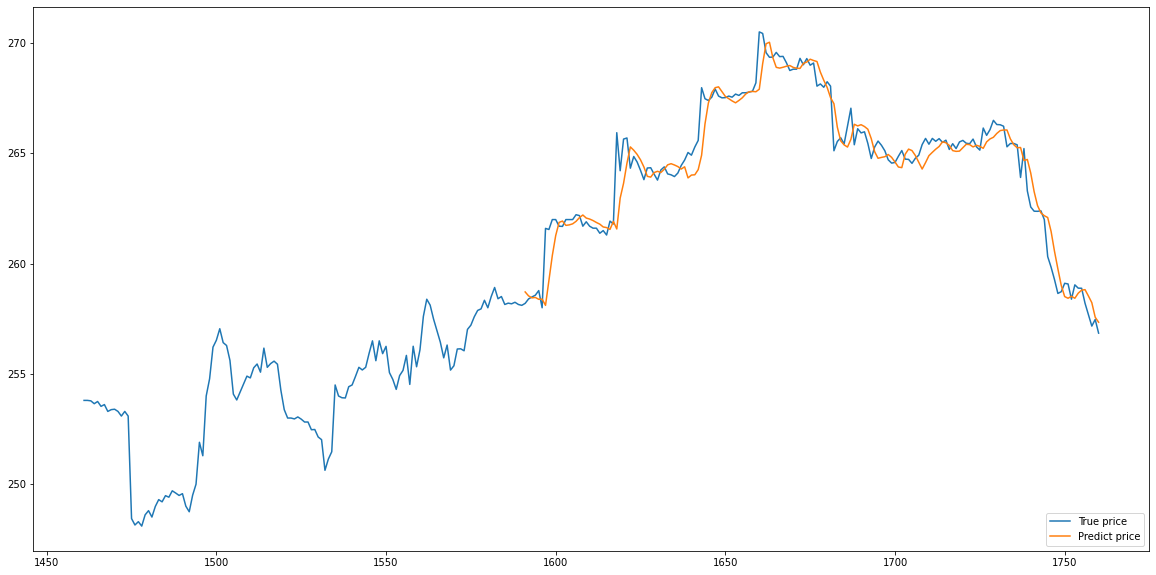

In [67]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
43/43 [==============================] - 8s 83ms/step - loss: 0.0426 - val_loss: 0.0030
Epoch 2/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 3/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/20
43/43 [==============================] - 3s 64ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


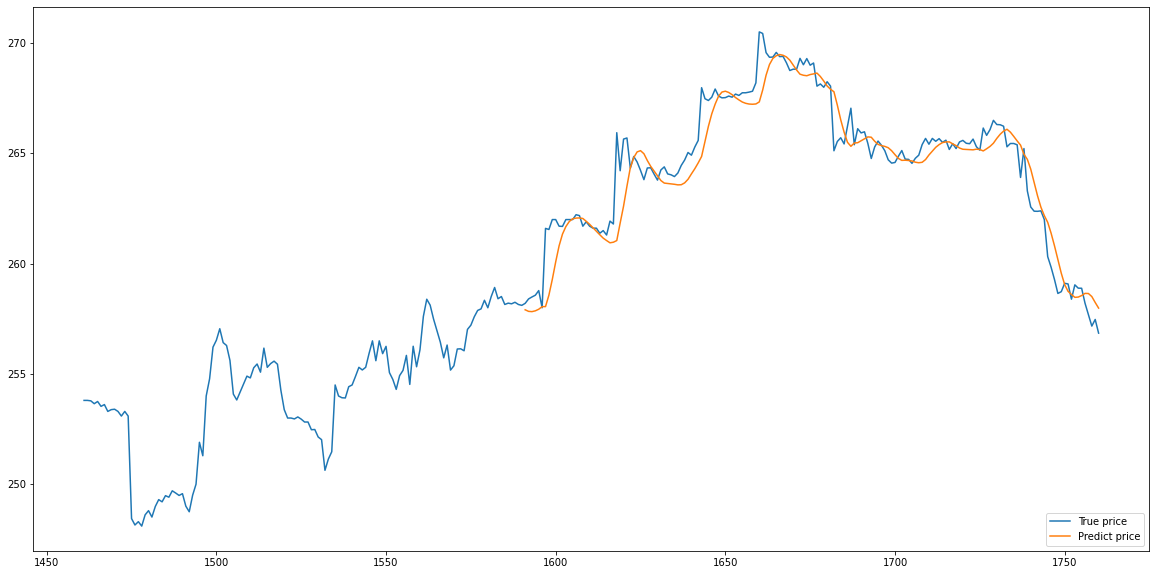

In [68]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
43/43 [==============================] - 9s 91ms/step - loss: 0.0337 - val_loss: 0.0045
Epoch 2/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/20
43/43 [==============================] - 3s 66ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 9/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


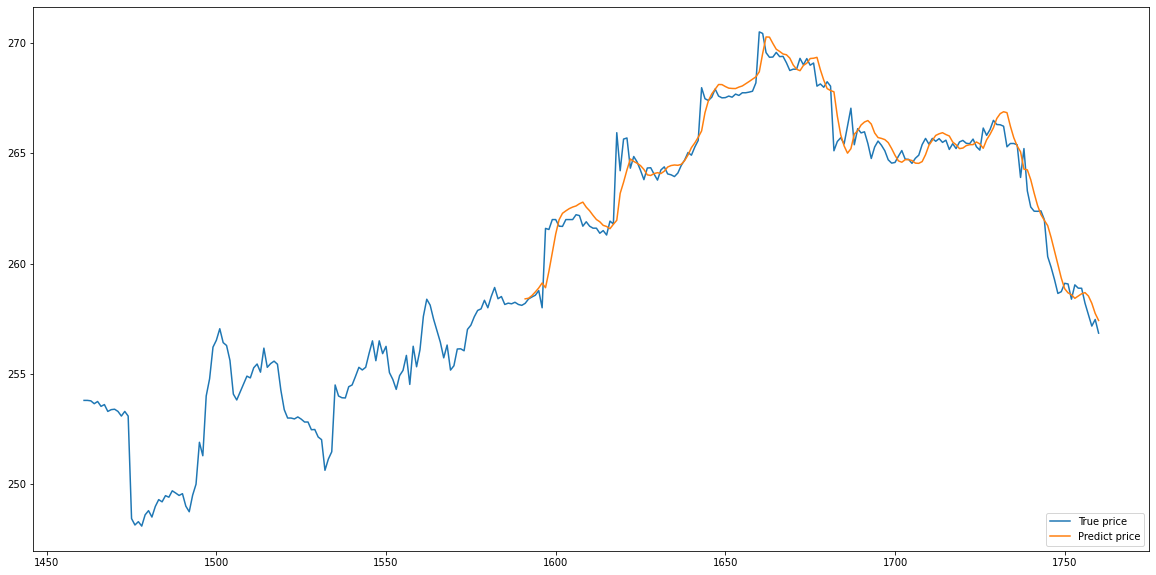

In [69]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
43/43 [==============================] - 8s 74ms/step - loss: 0.0345 - val_loss: 0.0035
Epoch 2/20
43/43 [==============================] - 2s 55ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 3/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 5/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 6/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/20
43/43 [==============================] - 2s 55ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 10/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


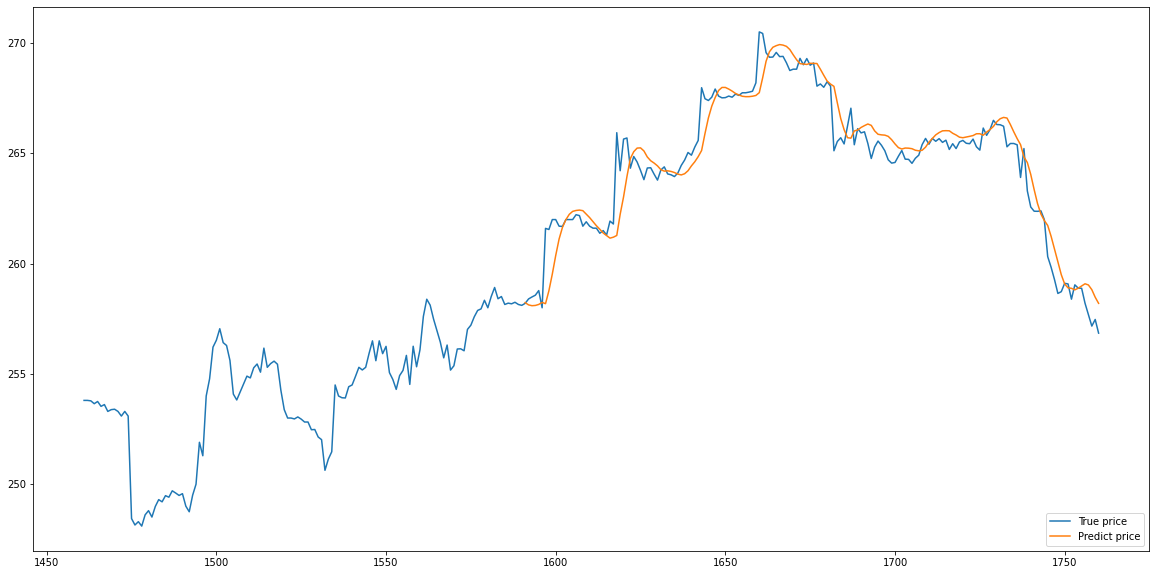

In [70]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
43/43 [==============================] - 7s 77ms/step - loss: 0.0314 - val_loss: 0.0038
Epoch 2/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 4/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 6/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 8/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 10/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


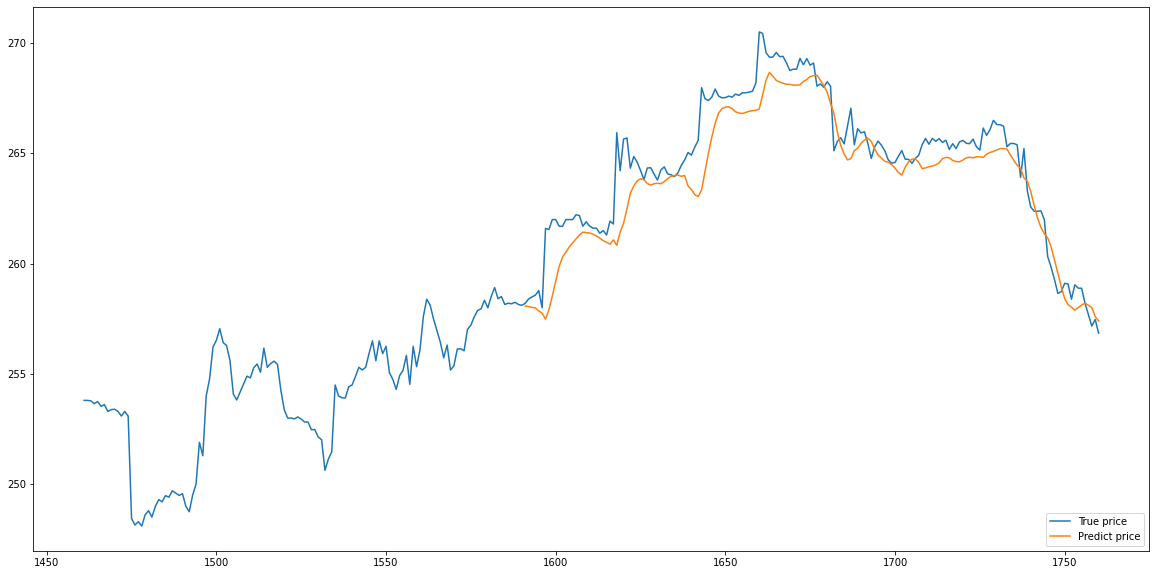

In [71]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
43/43 [==============================] - 7s 78ms/step - loss: 0.0337 - val_loss: 0.0028
Epoch 2/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 3/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 4/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


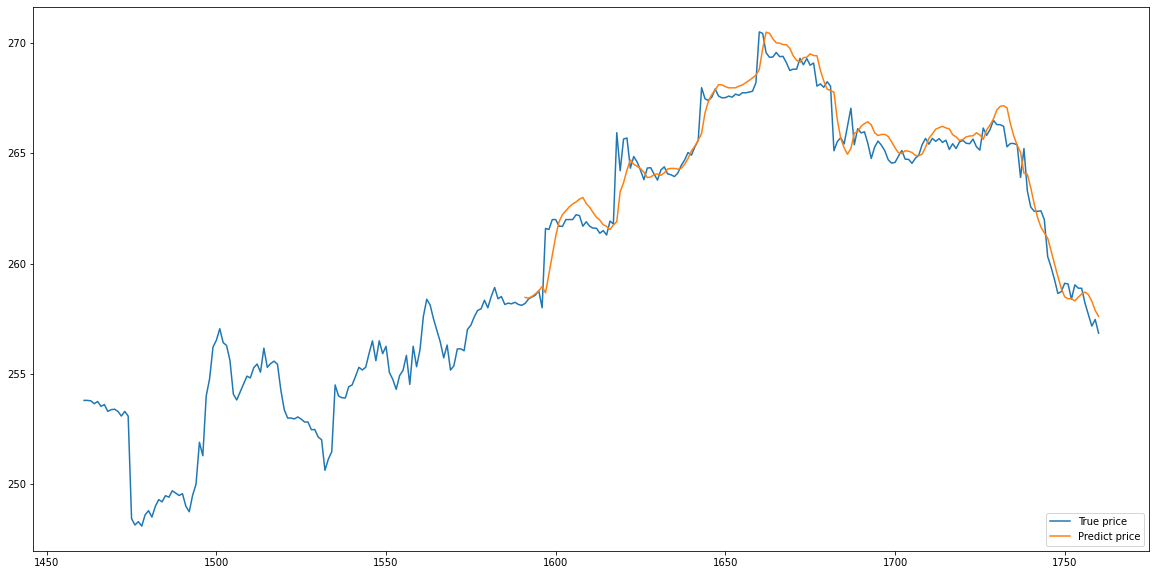

In [72]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
43/43 [==============================] - 7s 76ms/step - loss: 0.0232 - val_loss: 0.0038
Epoch 2/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 6/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 8/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 10/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


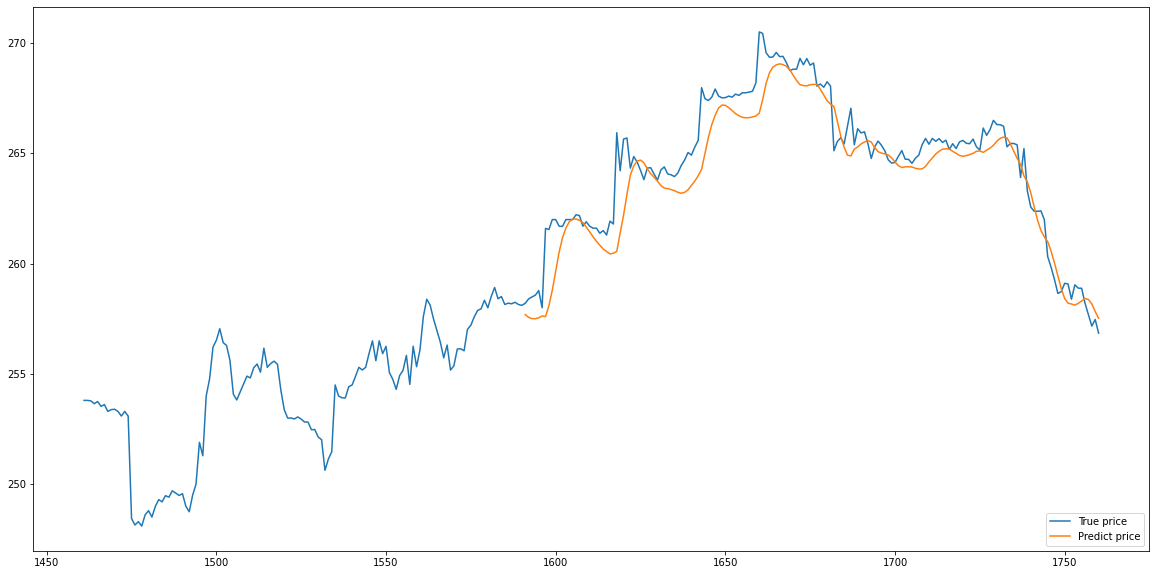

In [73]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
43/43 [==============================] - 7s 78ms/step - loss: 0.0304 - val_loss: 0.0028
Epoch 2/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


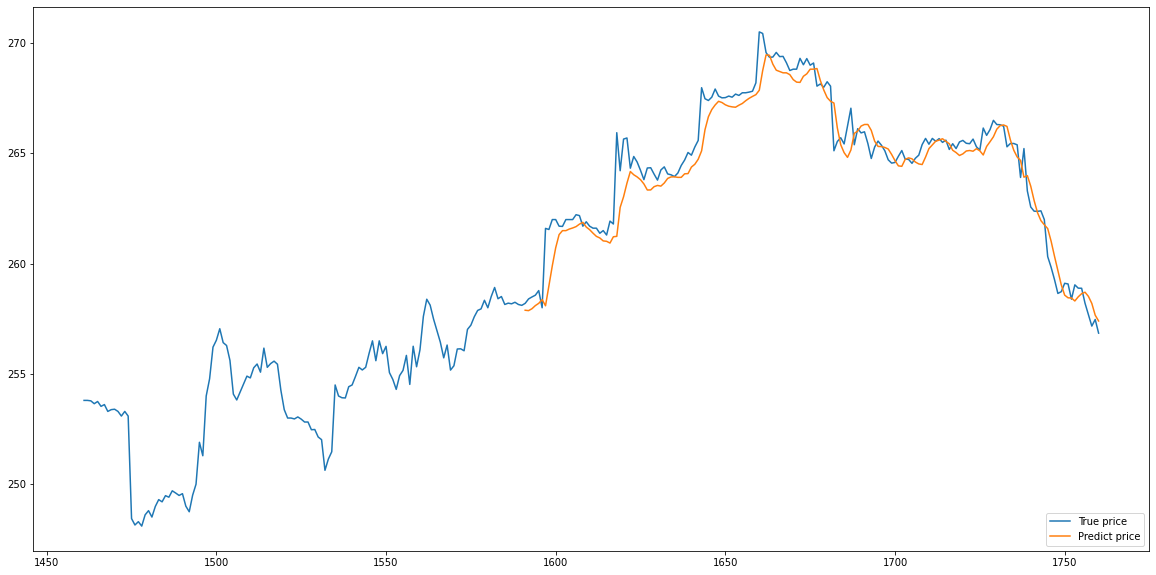

In [74]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
43/43 [==============================] - 7s 75ms/step - loss: 0.0232 - val_loss: 0.0025
Epoch 2/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 3/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 6/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


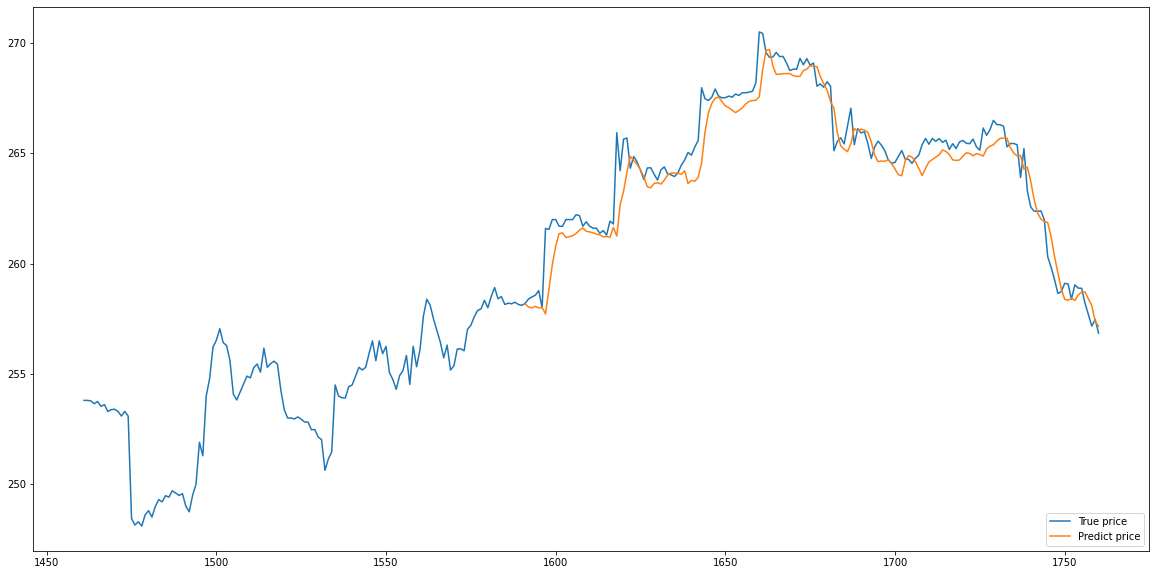

In [75]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
43/43 [==============================] - 7s 70ms/step - loss: 0.0225 - val_loss: 0.0039
Epoch 2/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/20
43/43 [==============================] - 2s 55ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


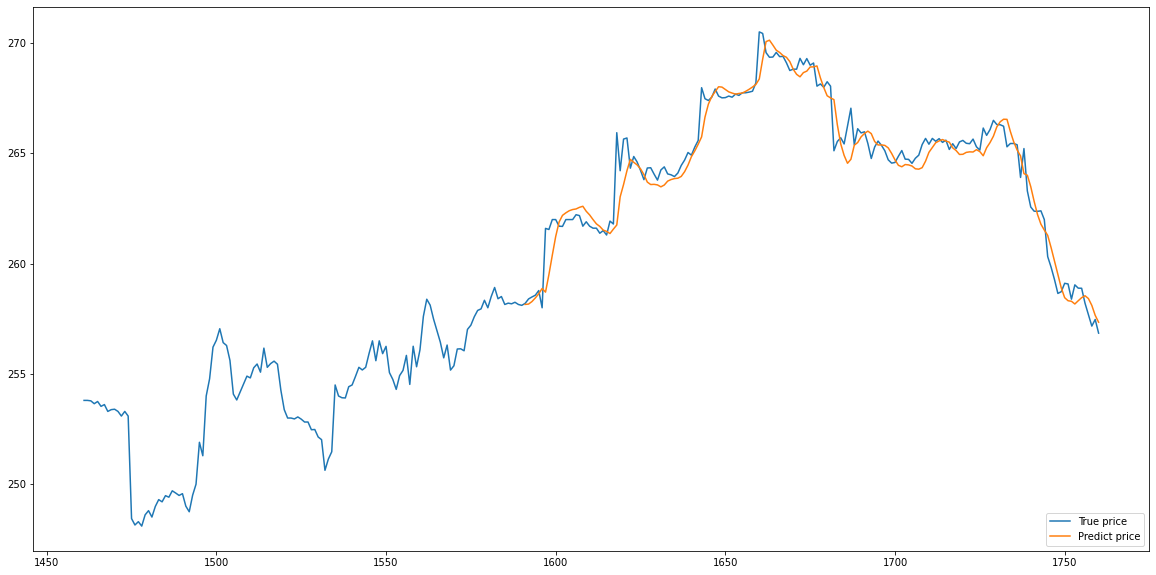

In [76]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
43/43 [==============================] - 7s 76ms/step - loss: 0.0506 - val_loss: 0.0033
Epoch 2/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 4/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


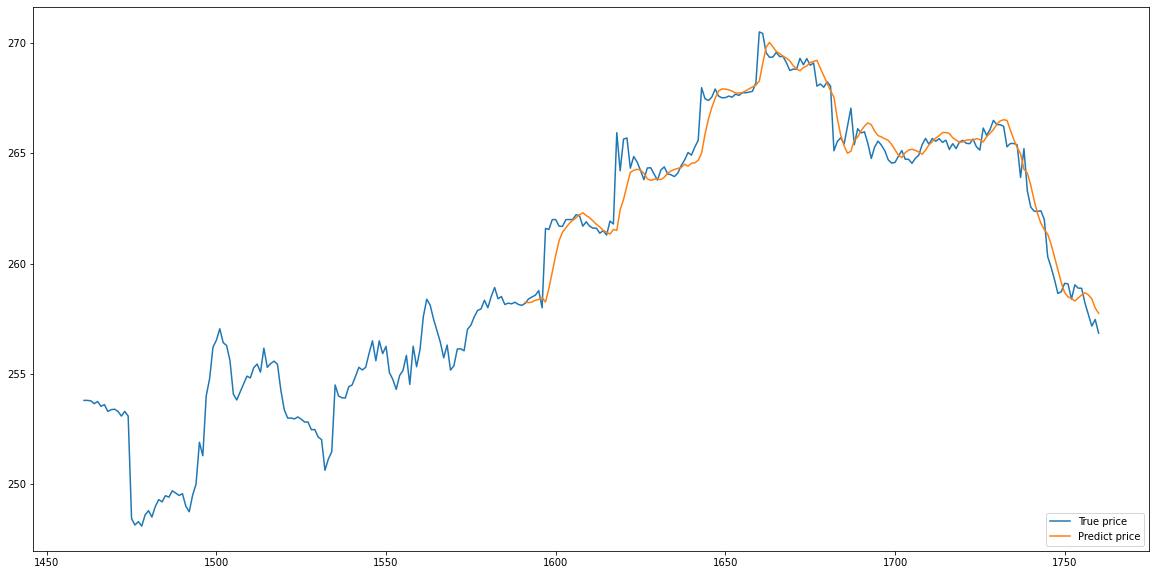

In [77]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
43/43 [==============================] - 7s 75ms/step - loss: 0.0302 - val_loss: 0.0047
Epoch 2/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 3/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 5/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


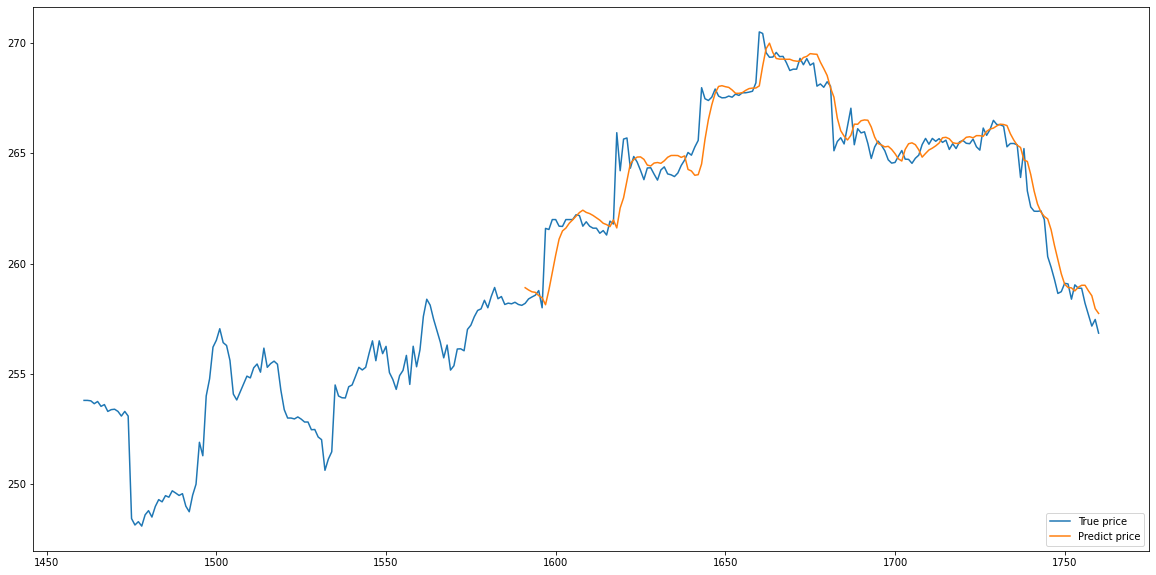

In [78]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
43/43 [==============================] - 7s 76ms/step - loss: 0.0342 - val_loss: 0.0036
Epoch 2/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 3/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/20
43/43 [==============================] - 3s 62ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


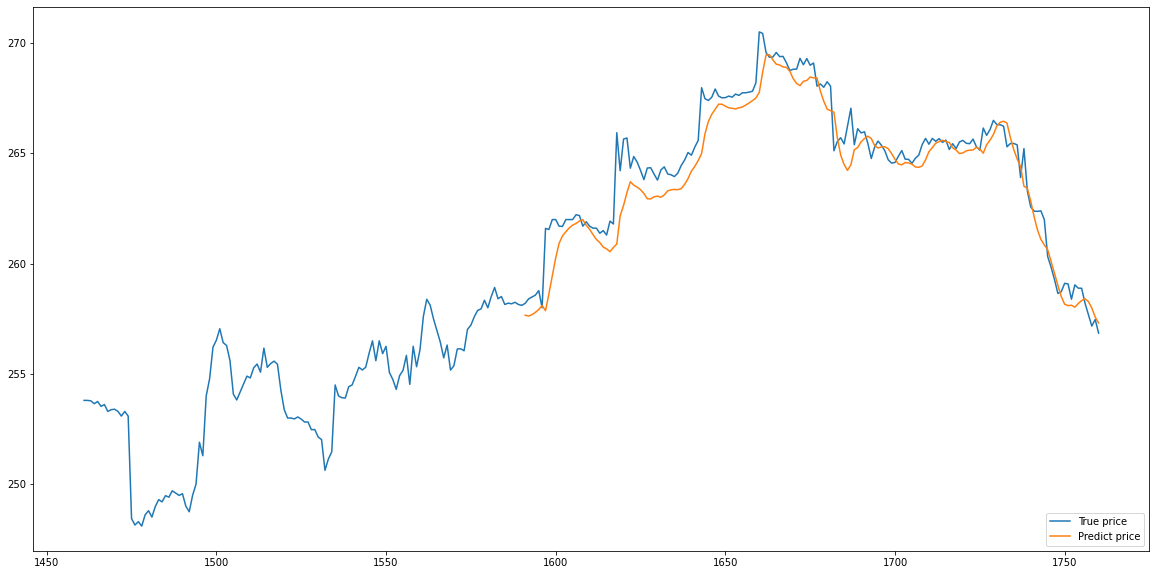

In [79]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
43/43 [==============================] - 7s 77ms/step - loss: 0.0268 - val_loss: 0.0028
Epoch 2/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 6/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/20
43/43 [==============================] - 3s 58ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


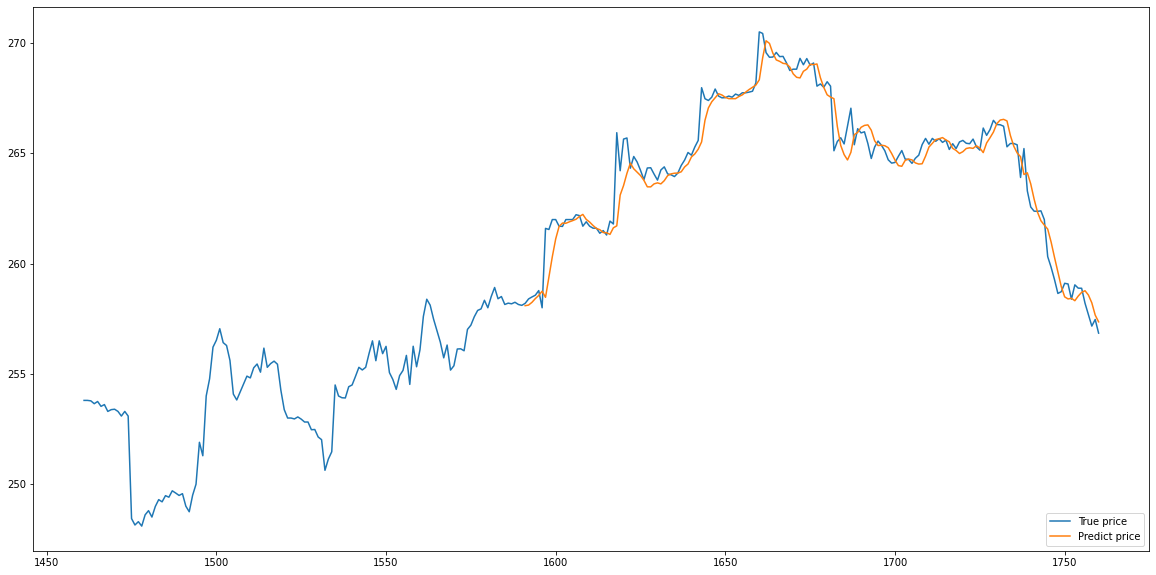

In [80]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
43/43 [==============================] - 7s 77ms/step - loss: 0.0213 - val_loss: 0.0024
Epoch 2/20
43/43 [==============================] - 2s 55ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/20
43/43 [==============================] - 3s 63ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/20
43/43 [==============================] - 3s 61ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 8/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/20
43/43 [==============================] - 3s 60ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


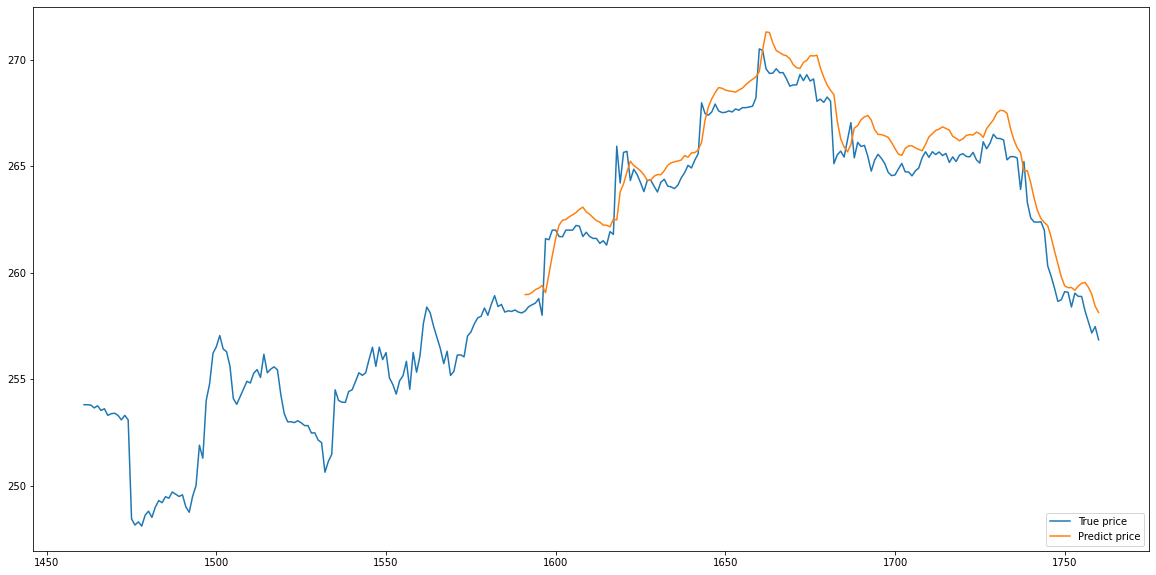

In [81]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [82]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [83]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[264.8936],
       [265.4922],
       [266.5578],
       ...,
       [257.17  ],
       [257.47  ],
       [256.85  ]])

In [84]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.64992519],
       [0.66682287],
       [0.69690332],
       ...,
       [0.43189838],
       [0.44036697],
       [0.42286521]])

In [85]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1701
1701


In [86]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1361, 60, 1)
Size validate:  (170, 60, 1)
Size test:  (170, 60, 1)


### b. Train Model

In [87]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
43/43 [==============================] - 14s 160ms/step - loss: 0.0419 - val_loss: 0.0045
Epoch 2/25
43/43 [==============================] - 5s 121ms/step - loss: 0.0099 - val_loss: 0.0052
Epoch 3/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 4/25
43/43 [==============================] - 5s 121ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 5/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0080 - val_loss: 0.0042
Epoch 6/25
43/43 [==============================] - 5s 122ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 7/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 8/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 9/25
43/43 [==============================] - 5s 122ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 10/25
43/43 [==============================] - 6s 134ms/step - loss: 0.0067 - val_loss: 0.003

### c. Test Model

In [88]:
model_rnn = load_model('./MODEL/RNN.h5')

In [89]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

6/6 [==============================] - 2s 36ms/step


In [90]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1591,2022-06-23 18:15:00,258.200,258.350,258.2000,258.2000,1608.0,0.8082,257.8890,57.5303,257.8890,254.621742,261.156258,257.839447
1592,2022-06-23 18:30:00,258.350,258.400,258.3000,258.4000,3827.0,0.8823,258.0020,58.6800,258.0020,254.954994,261.049006,257.717682
1593,2022-06-23 18:45:00,258.230,258.490,258.2300,258.4900,2258.0,0.9529,258.1240,59.2031,258.1240,255.334938,260.913062,257.626678
1594,2022-06-23 19:00:00,258.590,258.600,258.5700,258.5700,818.0,0.6030,258.2015,59.6807,258.2015,255.722034,260.680966,257.579468
1595,2022-06-23 19:45:00,258.770,258.790,258.4201,258.7800,1756.0,0.6104,258.2800,60.9441,258.2800,256.149311,260.410689,257.581146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,2022-06-28 14:15:00,258.900,259.420,258.0303,258.2055,551375.0,-2.7071,260.6285,26.6859,260.6285,259.572880,261.684120,258.533020
1757,2022-06-28 14:30:00,258.210,258.240,257.6400,257.6900,516855.0,-2.3569,260.3175,25.1375,260.3175,259.591047,261.043953,258.556061
1758,2022-06-28 14:45:00,257.680,257.726,256.8900,257.1700,626414.0,-3.0352,259.9150,23.6787,259.9150,259.366933,260.463067,258.569244
1759,2022-06-28 15:00:00,257.170,257.760,257.1300,257.4700,531378.0,-2.2142,259.6235,26.2769,259.6235,259.130109,260.116891,258.524017


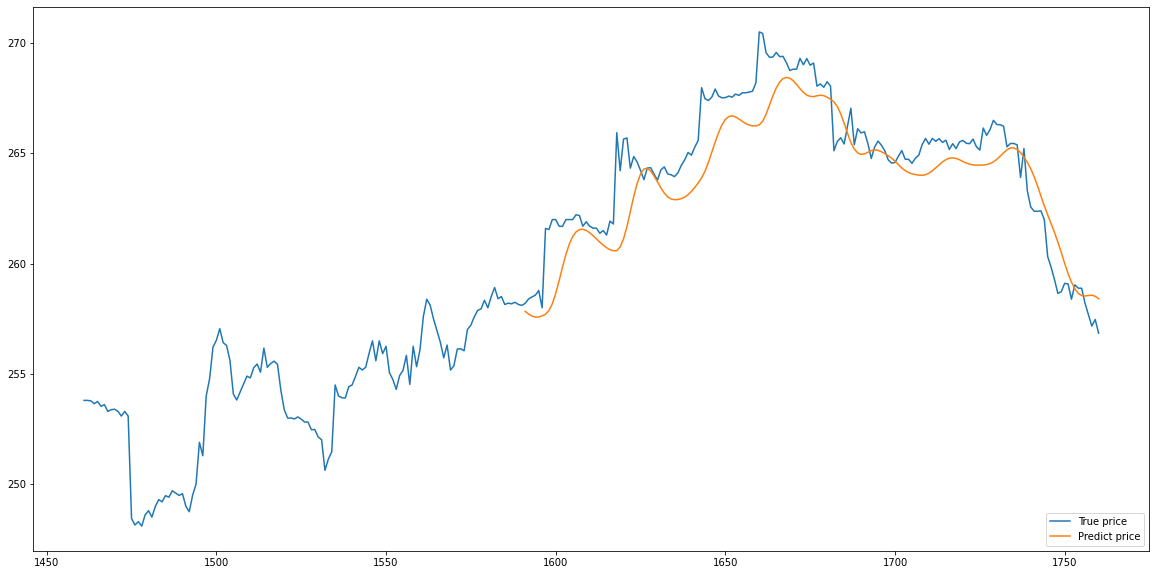

In [91]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [92]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.648936e+02,  1.471000e-01],
       [ 2.654922e+02,  2.411000e-01],
       [ 2.665578e+02,  2.695000e-01],
       ...,
       [ 2.571700e+02, -3.035200e+00],
       [ 2.574700e+02, -2.214200e+00],
       [ 2.568500e+02, -2.178500e+00]])

In [93]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.64992519, 0.57876809],
       [0.66682287, 0.59080548],
       [0.69690332, 0.59444231],
       ...,
       [0.43189838, 0.17125112],
       [0.44036697, 0.27638622],
       [0.42286521, 0.28095787]])

In [94]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1701
1701


In [95]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1361, 60, 2)
Size validate:  (170, 60, 2)
Size test:  (170, 60, 2)


In [96]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
43/43 [==============================] - 15s 164ms/step - loss: 0.0381 - val_loss: 0.0040
Epoch 2/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 3/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0080 - val_loss: 0.0043
Epoch 4/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 5/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 6/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0071 - val_loss: 0.0035
Epoch 7/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0073 - val_loss: 0.0036
Epoch 8/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 9/25
43/43 [==============================] - 6s 128ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 10/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0059 - val_loss: 0.003

In [97]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [98]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

6/6 [==============================] - 2s 36ms/step


In [99]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1591,2022-06-23 18:15:00,258.200,258.350,258.2000,258.2000,1608.0,0.8082,257.8890,57.5303,257.8890,254.621742,261.156258,258.232819
1592,2022-06-23 18:30:00,258.350,258.400,258.3000,258.4000,3827.0,0.8823,258.0020,58.6800,258.0020,254.954994,261.049006,258.398804
1593,2022-06-23 18:45:00,258.230,258.490,258.2300,258.4900,2258.0,0.9529,258.1240,59.2031,258.1240,255.334938,260.913062,258.511749
1594,2022-06-23 19:00:00,258.590,258.600,258.5700,258.5700,818.0,0.6030,258.2015,59.6807,258.2015,255.722034,260.680966,258.574829
1595,2022-06-23 19:45:00,258.770,258.790,258.4201,258.7800,1756.0,0.6104,258.2800,60.9441,258.2800,256.149311,260.410689,258.580322
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,2022-06-28 14:15:00,258.900,259.420,258.0303,258.2055,551375.0,-2.7071,260.6285,26.6859,260.6285,259.572880,261.684120,258.543060
1757,2022-06-28 14:30:00,258.210,258.240,257.6400,257.6900,516855.0,-2.3569,260.3175,25.1375,260.3175,259.591047,261.043953,258.537445
1758,2022-06-28 14:45:00,257.680,257.726,256.8900,257.1700,626414.0,-3.0352,259.9150,23.6787,259.9150,259.366933,260.463067,258.520569
1759,2022-06-28 15:00:00,257.170,257.760,257.1300,257.4700,531378.0,-2.2142,259.6235,26.2769,259.6235,259.130109,260.116891,258.423279


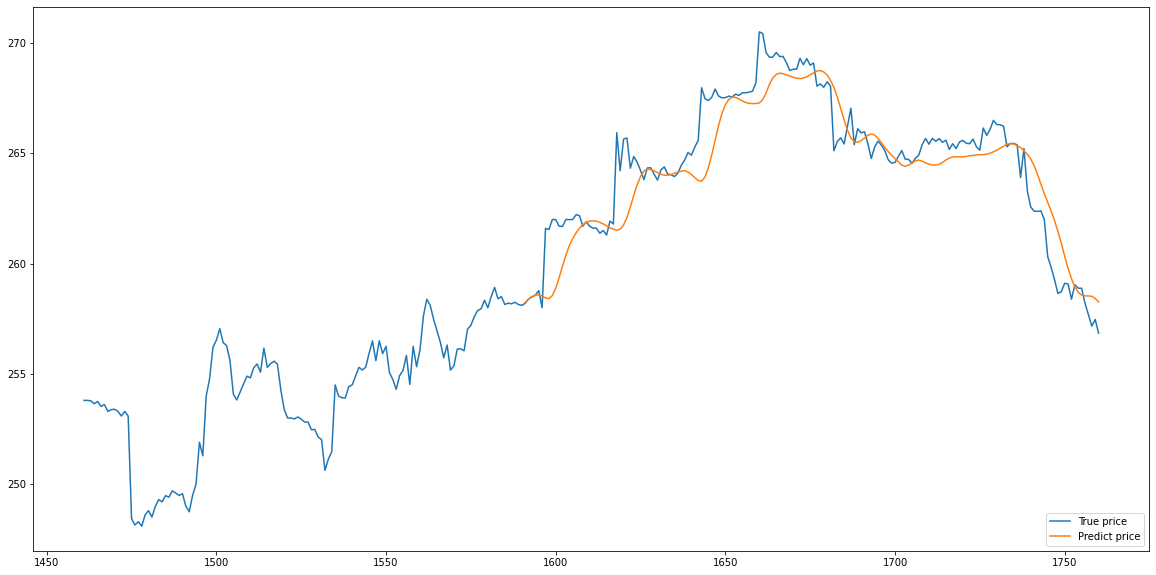

In [100]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
43/43 [==============================] - 14s 161ms/step - loss: 0.0422 - val_loss: 0.0061
Epoch 2/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0108 - val_loss: 0.0045
Epoch 3/25
43/43 [==============================] - 6s 129ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 4/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 5/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 6/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 7/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 8/25
43/43 [==============================] - 6s 135ms/step - loss: 0.0075 - val_loss: 0.0034
Epoch 9/25
43/43 [==============================] - 6s 127ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 10/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0065 - val_loss: 0.003

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


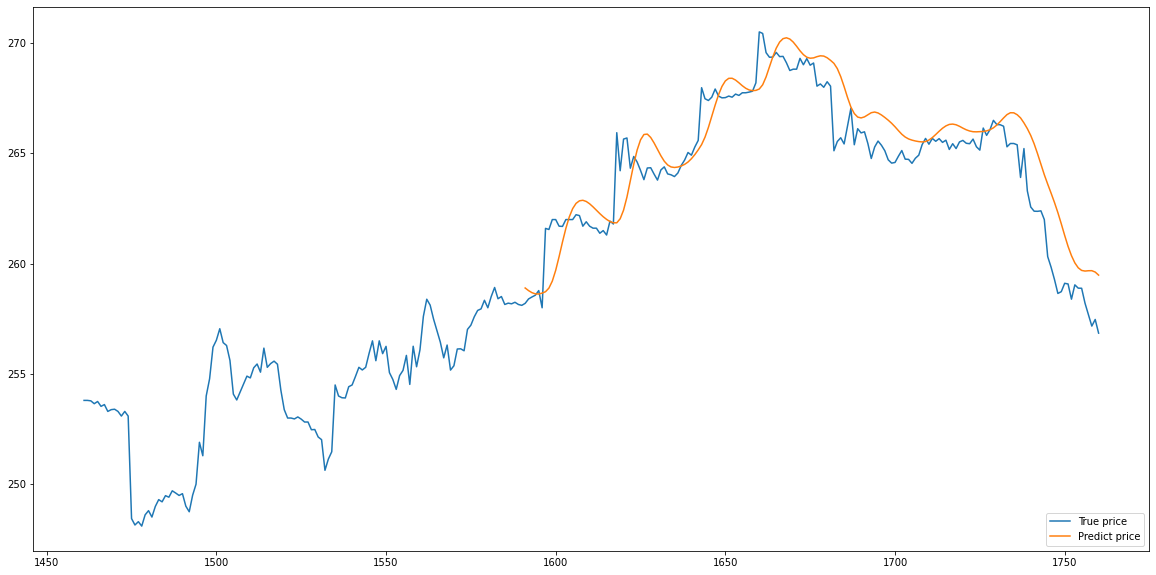

In [101]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
43/43 [==============================] - 15s 164ms/step - loss: 0.0388 - val_loss: 0.0051
Epoch 2/25
43/43 [==============================] - 5s 122ms/step - loss: 0.0099 - val_loss: 0.0046
Epoch 3/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 4/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0073 - val_loss: 0.0044
Epoch 5/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 6/25
43/43 [==============================] - 6s 129ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 7/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 8/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 9/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 10/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0069 - val_loss: 0.007

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


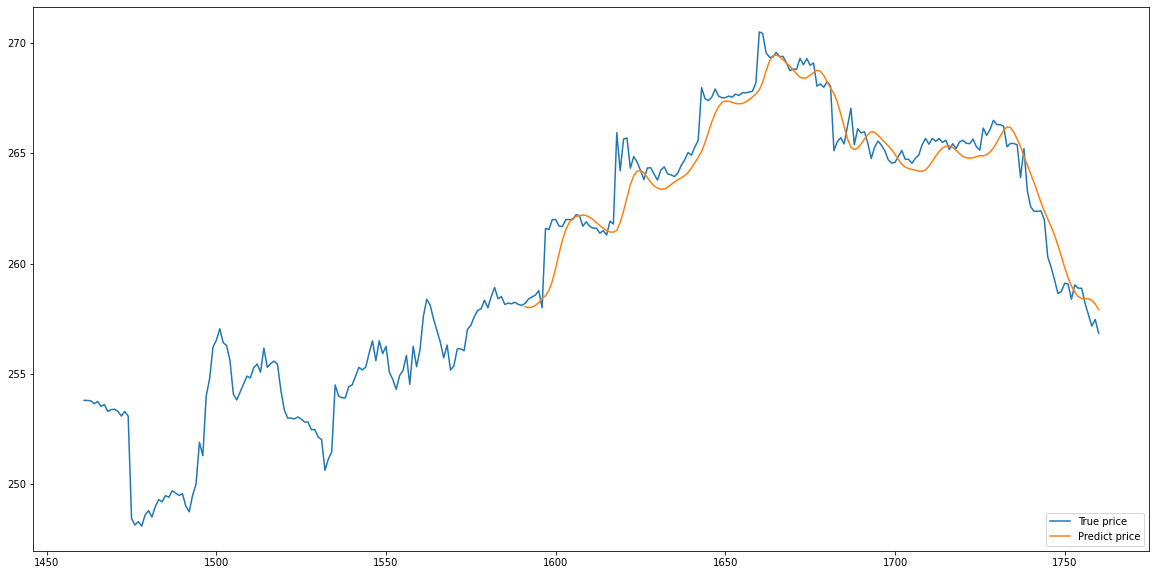

In [102]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
43/43 [==============================] - 15s 160ms/step - loss: 0.0401 - val_loss: 0.0074
Epoch 2/25
43/43 [==============================] - 5s 121ms/step - loss: 0.0105 - val_loss: 0.0052
Epoch 3/25
43/43 [==============================] - 5s 122ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 4/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0081 - val_loss: 0.0054
Epoch 5/25
43/43 [==============================] - 5s 122ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 6/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 7/25
43/43 [==============================] - 5s 121ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 8/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 9/25
43/43 [==============================] - 5s 120ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 10/25
43/43 [==============================] - 5s 121ms/step - loss: 0.0061 - val_loss: 0.006

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


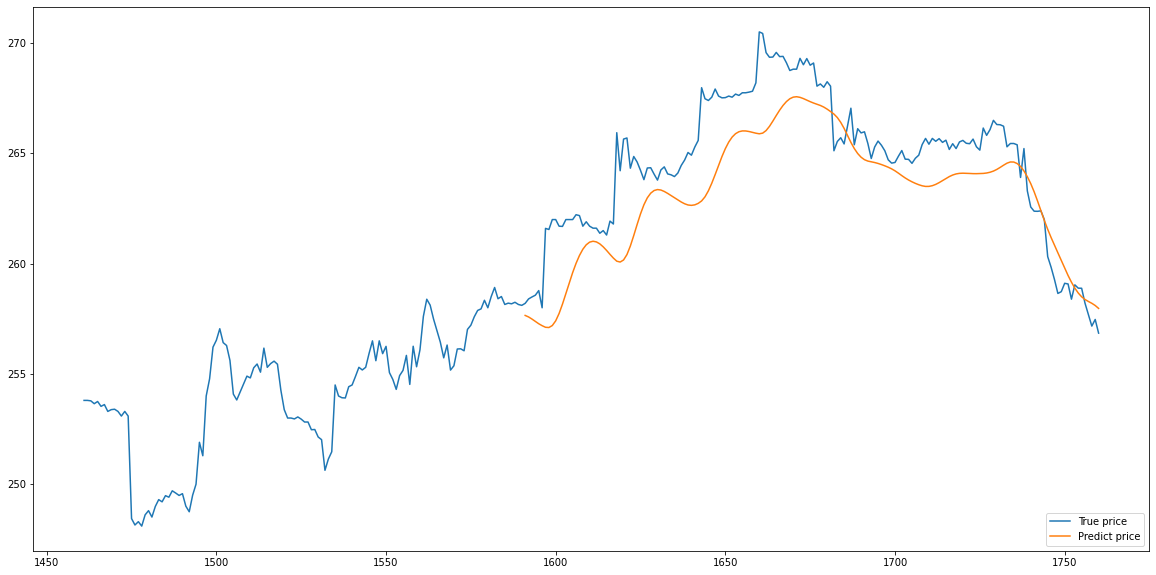

In [103]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
43/43 [==============================] - 14s 160ms/step - loss: 0.0425 - val_loss: 0.0082
Epoch 2/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 3/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 4/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 5/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 6/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 7/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 8/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 9/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 10/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0064 - val_loss: 0.005

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


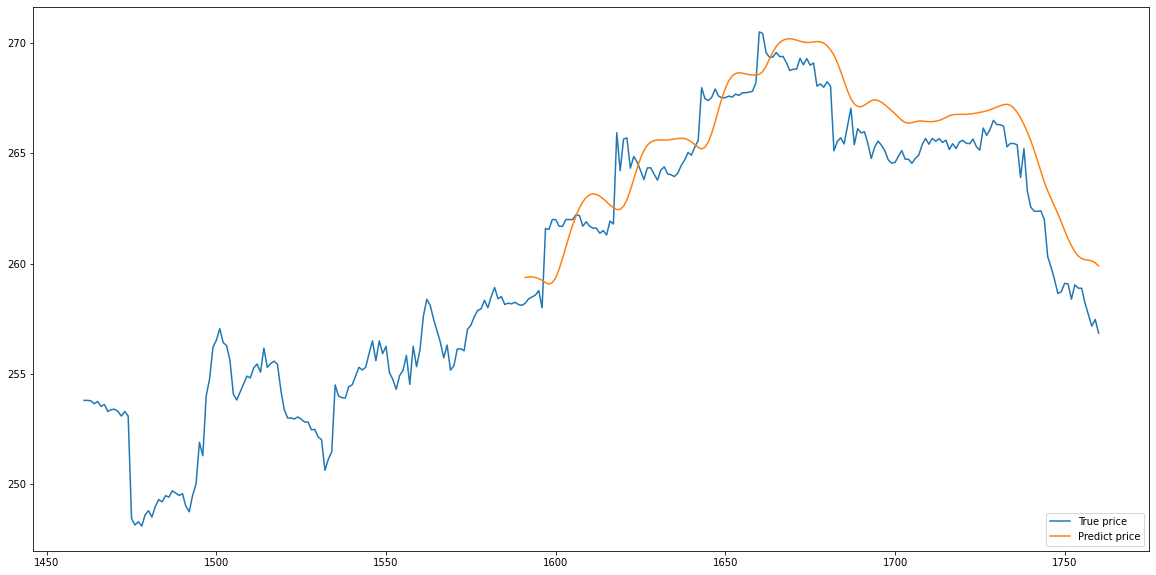

In [104]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
43/43 [==============================] - 15s 170ms/step - loss: 0.0403 - val_loss: 0.0067
Epoch 2/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0100 - val_loss: 0.0057
Epoch 3/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 4/25
43/43 [==============================] - 6s 128ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 5/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 6/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 7/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 8/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 9/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 10/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0053 - val_loss: 0.004

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


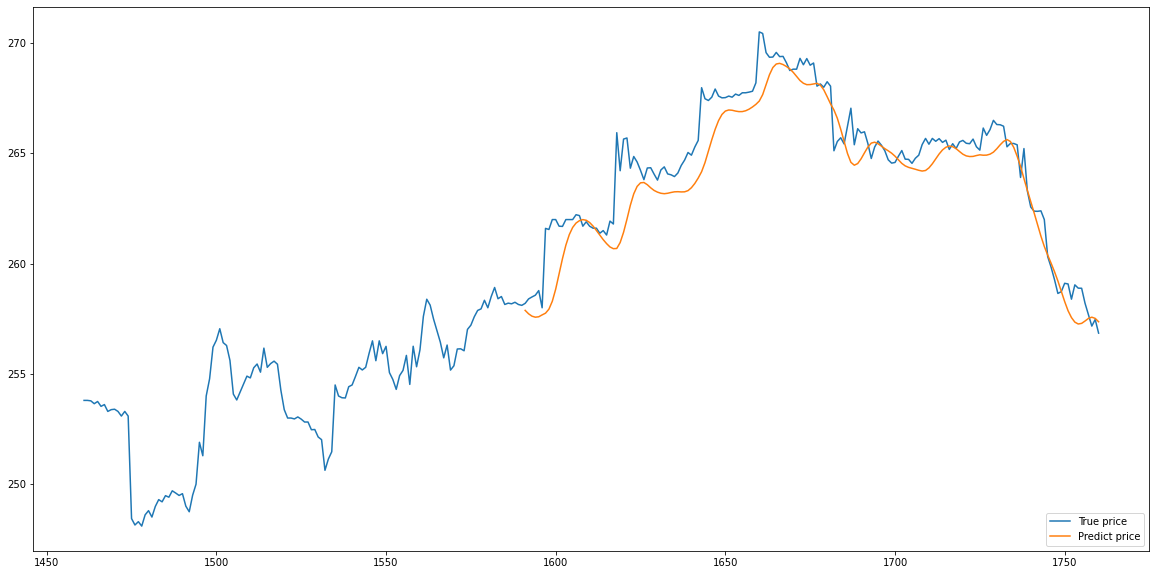

In [105]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
43/43 [==============================] - 15s 164ms/step - loss: 0.0372 - val_loss: 0.0098
Epoch 2/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0097 - val_loss: 0.0074
Epoch 3/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 4/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 5/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 6/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 7/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/25
43/43 [==============================] - 5s 123ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 9/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 10/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0061 - val_loss: 0.007

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


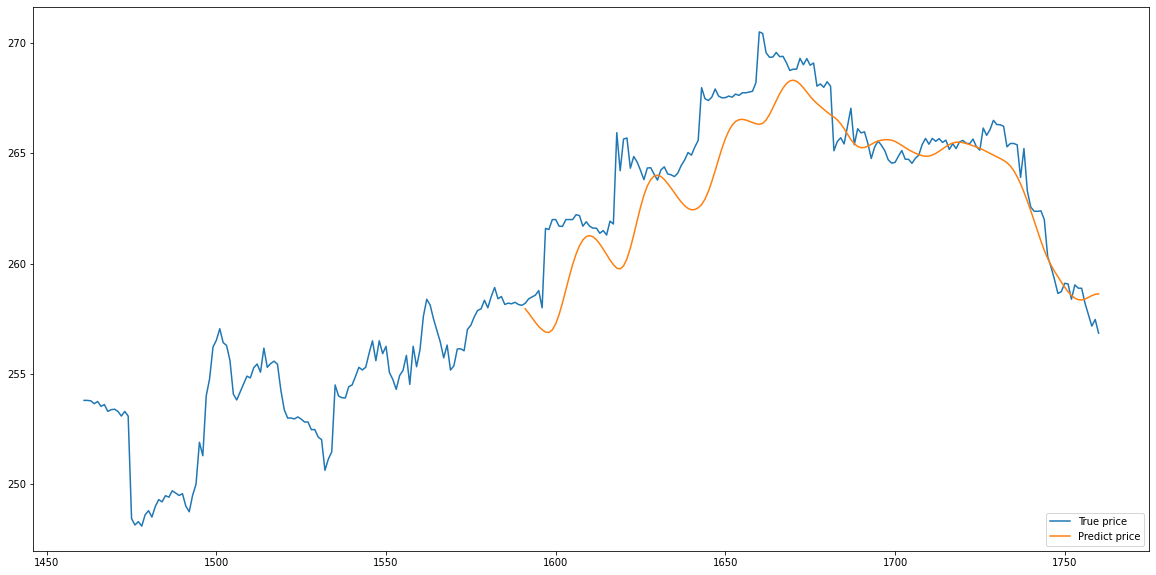

In [106]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
43/43 [==============================] - 26s 229ms/step - loss: 0.0474 - val_loss: 0.0041
Epoch 2/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0082 - val_loss: 0.0041
Epoch 3/25
43/43 [==============================] - 6s 140ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 4/25
43/43 [==============================] - 6s 147ms/step - loss: 0.0073 - val_loss: 0.0037
Epoch 5/25
43/43 [==============================] - 6s 146ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 6/25
43/43 [==============================] - 6s 146ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 7/25
43/43 [==============================] - 6s 152ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 8/25
43/43 [==============================] - 9s 203ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 9/25
43/43 [==============================] - 11s 233ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 10/25
43/43 [==============================] - 10s 219ms/step - loss: 0.0058 - val_loss: 0.0

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


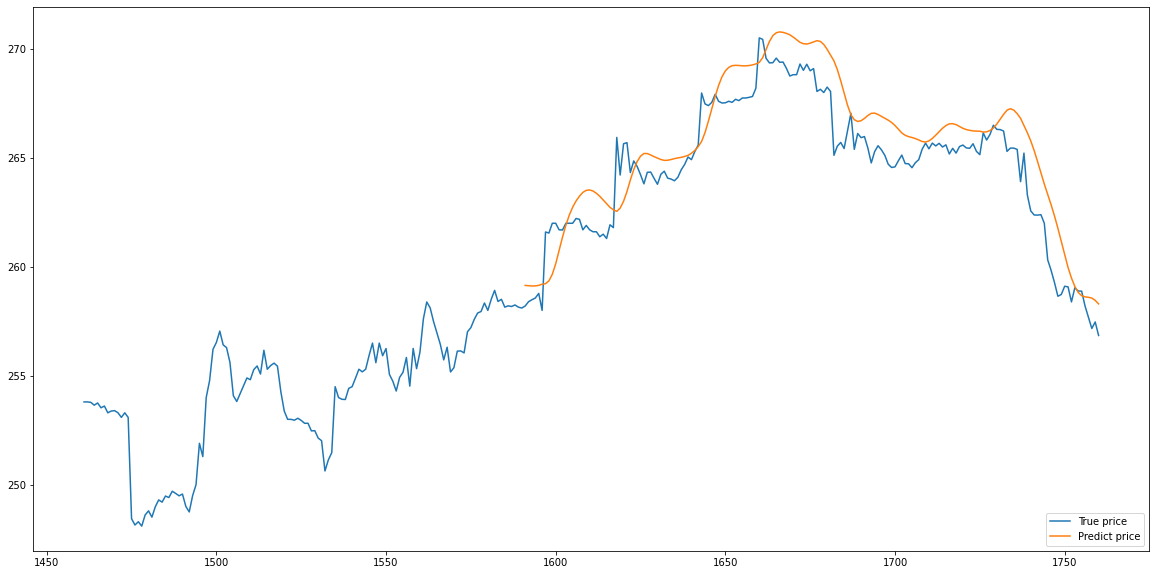

In [107]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
43/43 [==============================] - 18s 212ms/step - loss: 0.0461 - val_loss: 0.0068
Epoch 2/25
43/43 [==============================] - 7s 157ms/step - loss: 0.0114 - val_loss: 0.0044
Epoch 3/25
43/43 [==============================] - 7s 160ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 4/25
43/43 [==============================] - 7s 159ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 5/25
43/43 [==============================] - 7s 162ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 6/25
43/43 [==============================] - 7s 163ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 7/25
43/43 [==============================] - 7s 159ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 8/25
43/43 [==============================] - 7s 161ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 9/25
43/43 [==============================] - 7s 159ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 10/25
43/43 [==============================] - 7s 165ms/step - loss: 0.0061 - val_loss: 0.004

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


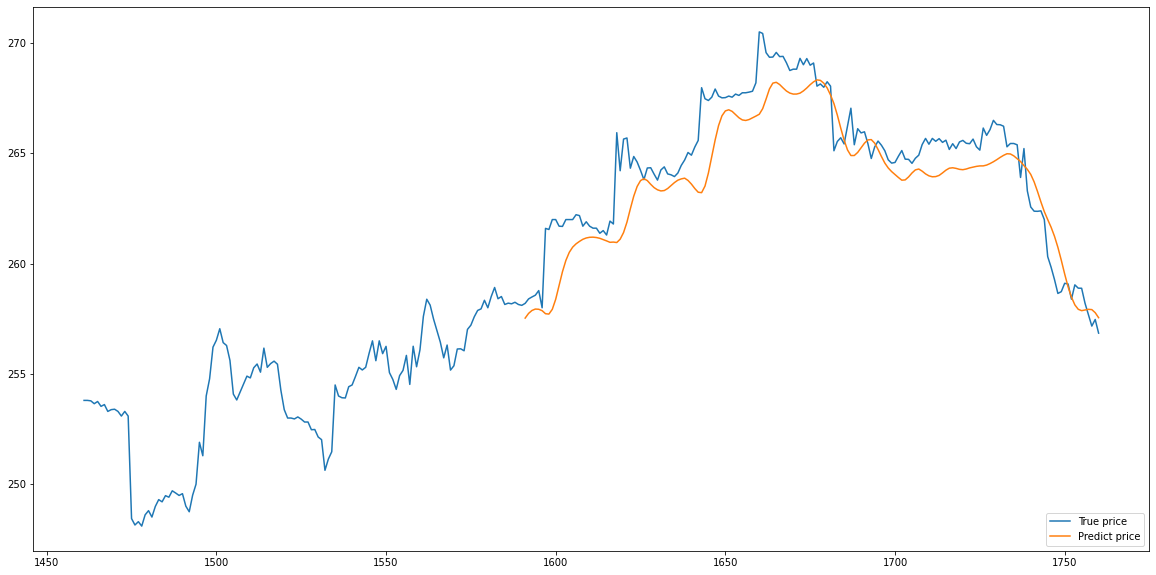

In [108]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
43/43 [==============================] - 20s 237ms/step - loss: 0.0507 - val_loss: 0.0075
Epoch 2/25
43/43 [==============================] - 7s 170ms/step - loss: 0.0099 - val_loss: 0.0045
Epoch 3/25
43/43 [==============================] - 7s 168ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 4/25
43/43 [==============================] - 7s 170ms/step - loss: 0.0079 - val_loss: 0.0039
Epoch 5/25
43/43 [==============================] - 7s 163ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 6/25
43/43 [==============================] - 7s 161ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 7/25
43/43 [==============================] - 7s 165ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 8/25
43/43 [==============================] - 7s 161ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 9/25
43/43 [==============================] - 7s 157ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 10/25
43/43 [==============================] - 7s 156ms/step - loss: 0.0054 - val_loss: 0.003

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


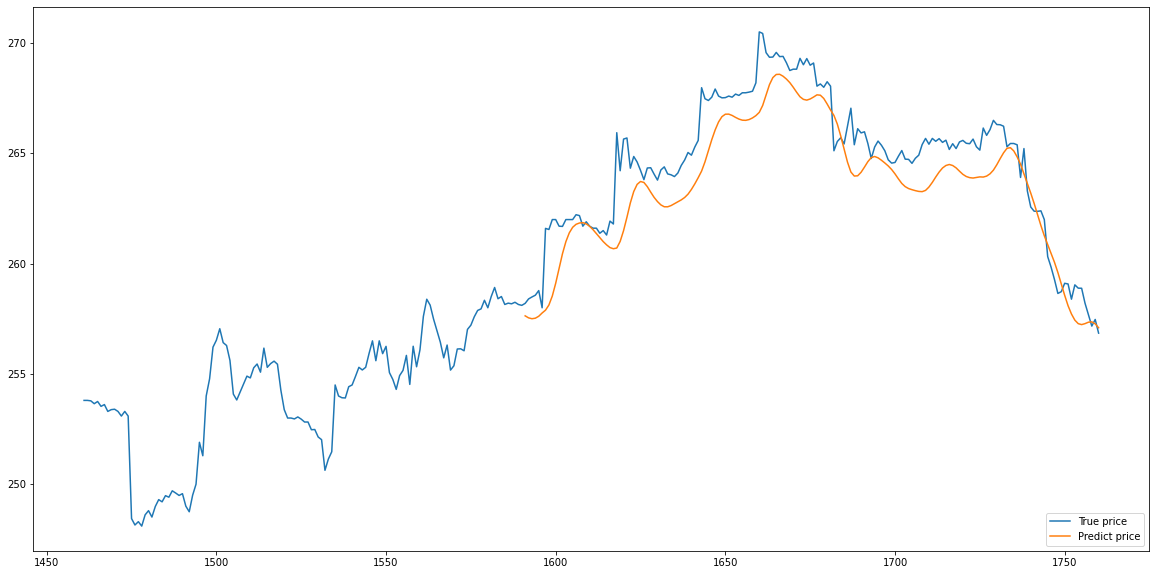

In [109]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
43/43 [==============================] - 14s 166ms/step - loss: 0.0323 - val_loss: 0.0047
Epoch 2/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 3/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 4/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 6/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 7/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 8/25
43/43 [==============================] - 6s 134ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 9/25
43/43 [==============================] - 6s 134ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 10/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0057 - val_loss: 0.004

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


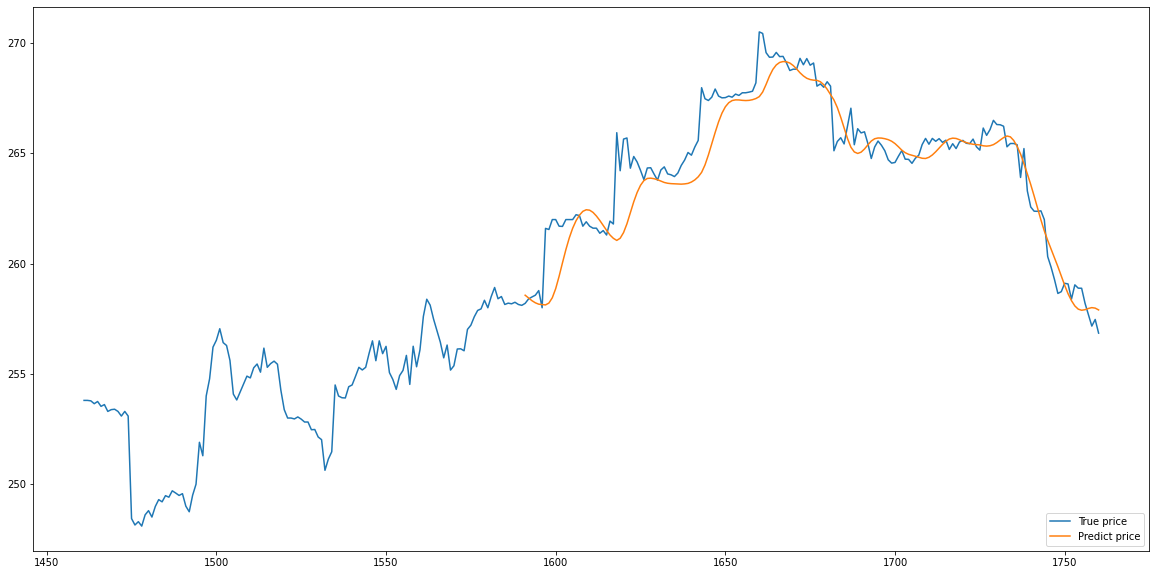

In [110]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
43/43 [==============================] - 15s 169ms/step - loss: 0.0413 - val_loss: 0.0054
Epoch 2/25
43/43 [==============================] - 6s 131ms/step - loss: 0.0108 - val_loss: 0.0058
Epoch 3/25
43/43 [==============================] - 7s 164ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 4/25
43/43 [==============================] - 7s 155ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 5/25
43/43 [==============================] - 7s 155ms/step - loss: 0.0080 - val_loss: 0.0053
Epoch 6/25
43/43 [==============================] - 7s 154ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 7/25
43/43 [==============================] - 7s 152ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 8/25
43/43 [==============================] - 6s 150ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 9/25
43/43 [==============================] - 6s 149ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 10/25
43/43 [==============================] - 6s 151ms/step - loss: 0.0064 - val_loss: 0.005

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


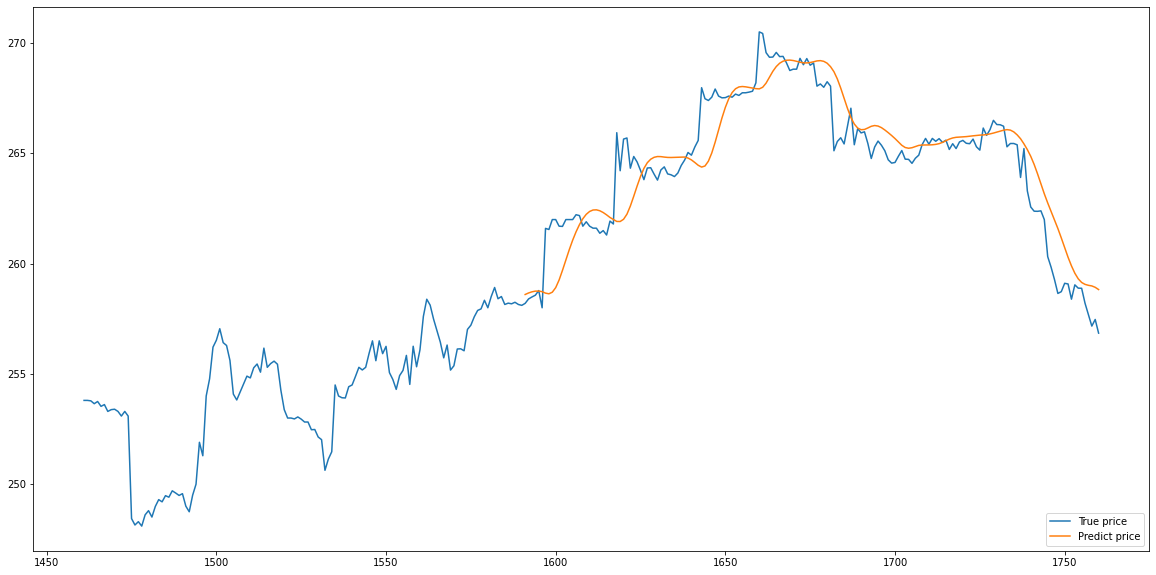

In [111]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
43/43 [==============================] - 14s 165ms/step - loss: 0.0280 - val_loss: 0.0052
Epoch 2/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0098 - val_loss: 0.0049
Epoch 3/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0084 - val_loss: 0.0048
Epoch 4/25
43/43 [==============================] - 8s 183ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 5/25
43/43 [==============================] - 8s 179ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 6/25
43/43 [==============================] - 7s 158ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 7/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 8/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 9/25
43/43 [==============================] - 6s 129ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 10/25
43/43 [==============================] - 6s 128ms/step - loss: 0.0047 - val_loss: 0.003

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


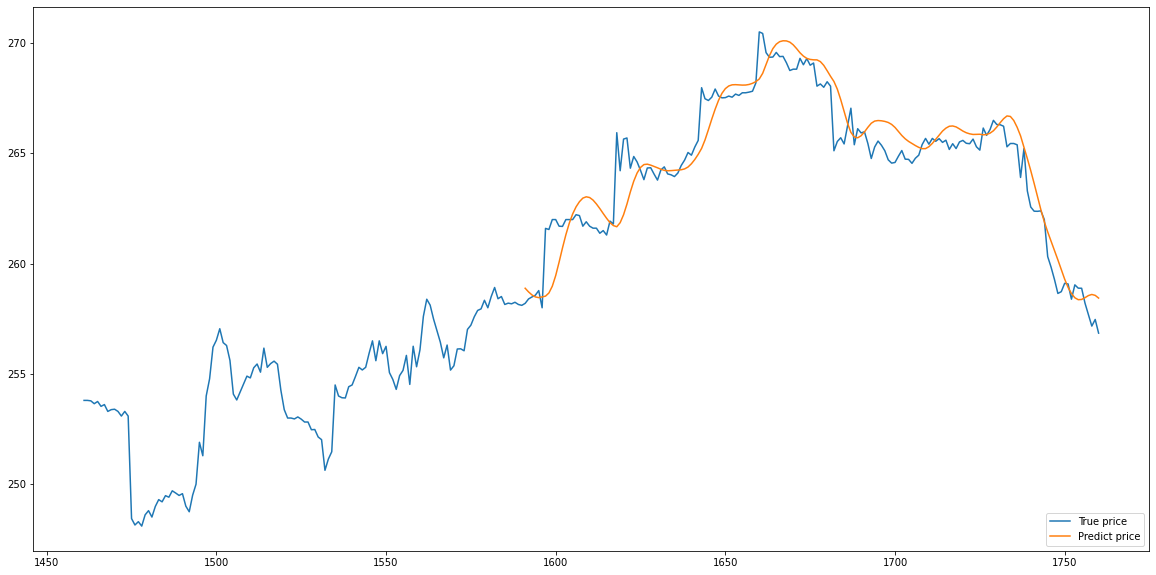

In [112]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
43/43 [==============================] - 14s 164ms/step - loss: 0.0405 - val_loss: 0.0048
Epoch 2/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0094 - val_loss: 0.0043
Epoch 3/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 4/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 5/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 6/25
43/43 [==============================] - 6s 129ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 7/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 8/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 9/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0062 - val_loss: 0.0034
Epoch 10/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0054 - val_loss: 0.003

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


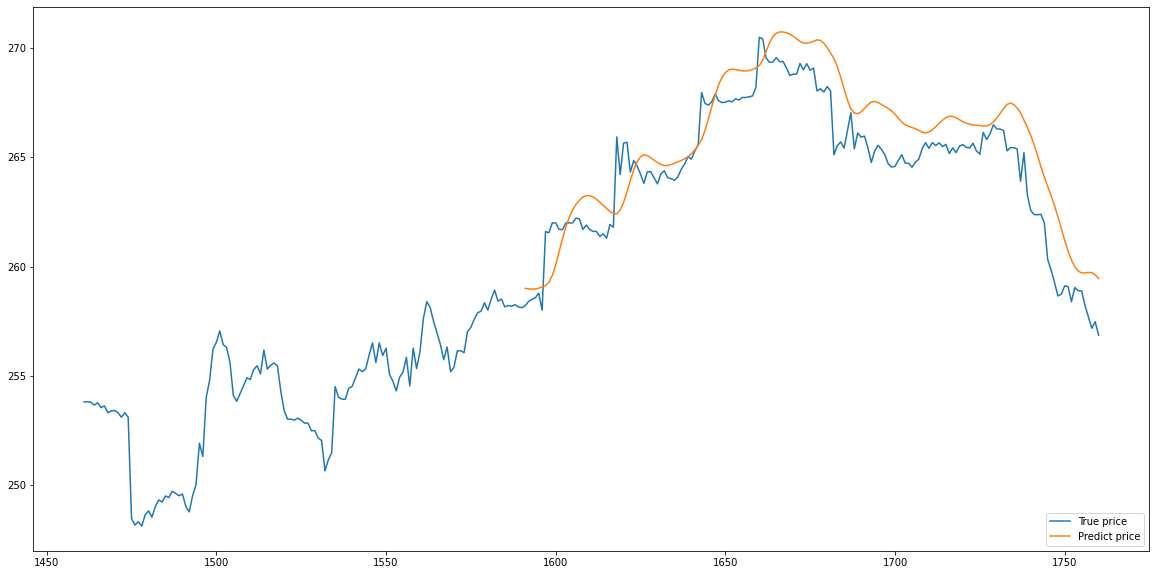

In [113]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
43/43 [==============================] - 14s 162ms/step - loss: 0.0307 - val_loss: 0.0047
Epoch 2/25
43/43 [==============================] - 5s 125ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 4/25
43/43 [==============================] - 6s 129ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 5/25
43/43 [==============================] - 5s 126ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 6/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 7/25
43/43 [==============================] - 5s 124ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 8/25
43/43 [==============================] - 5s 127ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 9/25
43/43 [==============================] - 6s 130ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 10/25
43/43 [==============================] - 5s 128ms/step - loss: 0.0051 - val_loss: 0.003

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


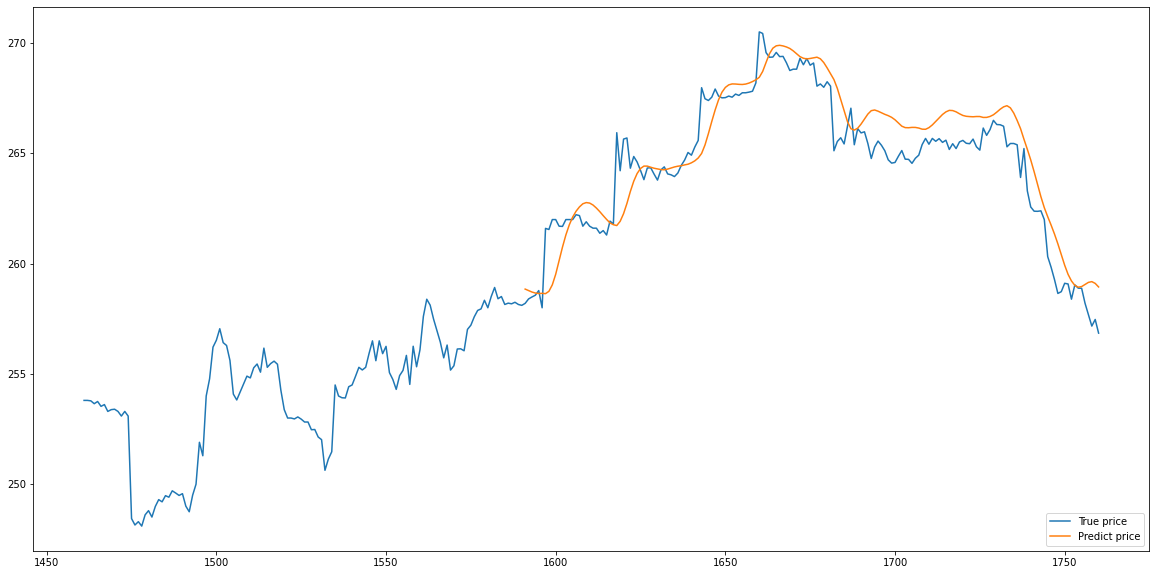

In [114]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [115]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

,close,volume
0,264.8936,38171.0
1,265.4922,64319.0
2,266.5578,2397104.0
3,265.0832,1711465.0
4,264.4397,1220319.0
...,...,...
1756,258.2055,551375.0
1757,257.6900,516855.0
1758,257.1700,626414.0
1759,257.4700,531378.0


In [116]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2
0,264.8936,38171.0,NaN,NaN,NaN,NaN
1,265.4922,64319.0,264.8936,38171.0,NaN,NaN
2,266.5578,2397104.0,265.4922,64319.0,264.8936,38171.0
3,265.0832,1711465.0,266.5578,2397104.0,265.4922,64319.0
4,264.4397,1220319.0,265.0832,1711465.0,266.5578,2397104.0
...,...,...,...,...,...,...
1756,258.2055,551375.0,258.8850,450955.0,258.8900,474568.0
1757,257.6900,516855.0,258.2055,551375.0,258.8850,450955.0
1758,257.1700,626414.0,257.6900,516855.0,258.2055,551375.0
1759,257.4700,531378.0,257.1700,626414.0,257.6900,516855.0


In [117]:
dataset.dropna(inplace=True)
dataset

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2
2,266.5578,2397104.0,265.4922,64319.0,264.8936,38171.0
3,265.0832,1711465.0,266.5578,2397104.0,265.4922,64319.0
4,264.4397,1220319.0,265.0832,1711465.0,266.5578,2397104.0
5,263.7193,962749.0,264.4397,1220319.0,265.0832,1711465.0
6,262.4045,976394.0,263.7193,962749.0,264.4397,1220319.0
...,...,...,...,...,...,...
1756,258.2055,551375.0,258.8850,450955.0,258.8900,474568.0
1757,257.6900,516855.0,258.2055,551375.0,258.8850,450955.0
1758,257.1700,626414.0,257.6900,516855.0,258.2055,551375.0
1759,257.4700,531378.0,257.1700,626414.0,257.6900,516855.0


In [118]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1759, 4)
(1759, 1)


,close_date_1,volume_date_1,close_date_2,volume_date_2
2,265.4922,64319.0,264.8936,38171.0
3,266.5578,2397104.0,265.4922,64319.0
4,265.0832,1711465.0,266.5578,2397104.0
5,264.4397,1220319.0,265.0832,1711465.0
6,263.7193,962749.0,264.4397,1220319.0
...,...,...,...,...
1756,258.8850,450955.0,258.8900,474568.0
1757,258.2055,551375.0,258.8850,450955.0
1758,257.6900,516855.0,258.2055,551375.0
1759,257.1700,626414.0,257.6900,516855.0


In [119]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1584, 4)
Size test:  (175, 4)


### b. Train Model

In [120]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [121]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [122]:
predictions = model_xgboost.predict(X_test)
predictions

array([257.8845 , 258.05774, 257.80032, 257.49857, 257.9586 , 257.7571 ,
       257.67285, 257.87595, 258.92126, 258.7703 , 258.6394 , 257.91064,
       261.5236 , 261.52444, 261.7178 , 261.99066, 261.86578, 261.64417,
       261.7634 , 261.9995 , 262.631  , 262.00818, 261.86685, 261.77954,
       261.464  , 261.58304, 261.48077, 261.50726, 260.40353, 261.61057,
       260.34354, 261.5084 , 261.35043, 265.3253 , 264.47983, 265.05518,
       266.05313, 264.80734, 265.31827, 264.86328, 263.7189 , 263.59686,
       263.70044, 264.5862 , 263.93005, 263.70663, 263.70093, 264.882  ,
       263.80695, 263.62503, 263.41556, 263.61823, 264.9154 , 264.8054 ,
       264.6393 , 264.79608, 264.9417 , 265.17087, 267.60953, 267.6704 ,
       267.12842, 267.5532 , 267.81262, 267.51752, 267.20645, 267.57486,
       267.75638, 267.54532, 267.4146 , 267.50803, 267.67578, 267.62848,
       267.39313, 267.79913, 268.07526, 270.12012, 270.44055, 269.7374 ,
       269.53128, 269.24954, 269.2494 , 268.9853 , 

In [123]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2,predictions
1586,258.2100,23958.0,258.1500,14725.0,258.5100,22881.0,257.884491
1587,258.1801,2214.0,258.2100,23958.0,258.1500,14725.0,258.057739
1588,258.2500,104.0,258.1801,2214.0,258.2100,23958.0,257.800323
1589,258.1500,976.0,258.2500,104.0,258.1801,2214.0,257.498566
1590,258.1100,2638.0,258.1500,976.0,258.2500,104.0,257.958588
...,...,...,...,...,...,...,...
1756,258.2055,551375.0,258.8850,450955.0,258.8900,474568.0,258.709900
1757,257.6900,516855.0,258.2055,551375.0,258.8850,450955.0,258.033966
1758,257.1700,626414.0,257.6900,516855.0,258.2055,551375.0,257.865540
1759,257.4700,531378.0,257.1700,626414.0,257.6900,516855.0,257.246765


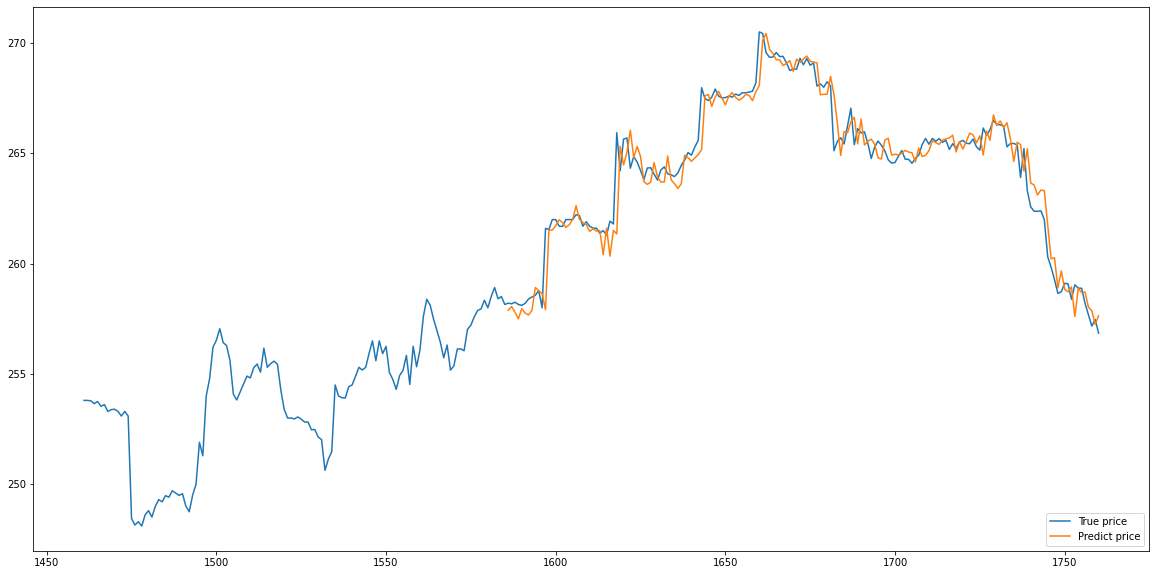

In [124]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [125]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

,close,volume,ROC
0,264.8936,38171.0,0.1471
1,265.4922,64319.0,0.2411
2,266.5578,2397104.0,0.2695
3,265.0832,1711465.0,-0.2889
4,264.4397,1220319.0,-0.4114
...,...,...,...
1756,258.2055,551375.0,-2.7071
1757,257.6900,516855.0,-2.3569
1758,257.1700,626414.0,-3.0352
1759,257.4700,531378.0,-2.2142


In [126]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2
0,264.8936,38171.0,0.1471,NaN,NaN,NaN,NaN,NaN,NaN
1,265.4922,64319.0,0.2411,264.8936,38171.0,0.1471,NaN,NaN,NaN
2,266.5578,2397104.0,0.2695,265.4922,64319.0,0.2411,264.8936,38171.0,0.1471
3,265.0832,1711465.0,-0.2889,266.5578,2397104.0,0.2695,265.4922,64319.0,0.2411
4,264.4397,1220319.0,-0.4114,265.0832,1711465.0,-0.2889,266.5578,2397104.0,0.2695
...,...,...,...,...,...,...,...,...,...
1756,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732,258.8900,474568.0,-2.4713
1757,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732
1758,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071
1759,257.4700,531378.0,-2.2142,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569


In [127]:
dataset.dropna(inplace=True)
dataset

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2
2,266.5578,2397104.0,0.2695,265.4922,64319.0,0.2411,264.8936,38171.0,0.1471
3,265.0832,1711465.0,-0.2889,266.5578,2397104.0,0.2695,265.4922,64319.0,0.2411
4,264.4397,1220319.0,-0.4114,265.0832,1711465.0,-0.2889,266.5578,2397104.0,0.2695
5,263.7193,962749.0,-0.6715,264.4397,1220319.0,-0.4114,265.0832,1711465.0,-0.2889
6,262.4045,976394.0,-1.1816,263.7193,962749.0,-0.6715,264.4397,1220319.0,-0.4114
...,...,...,...,...,...,...,...,...,...
1756,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732,258.8900,474568.0,-2.4713
1757,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732
1758,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071
1759,257.4700,531378.0,-2.2142,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569


In [128]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1759, 6)
(1759, 1)


,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2
2,265.4922,64319.0,0.2411,264.8936,38171.0,0.1471
3,266.5578,2397104.0,0.2695,265.4922,64319.0,0.2411
4,265.0832,1711465.0,-0.2889,266.5578,2397104.0,0.2695
5,264.4397,1220319.0,-0.4114,265.0832,1711465.0,-0.2889
6,263.7193,962749.0,-0.6715,264.4397,1220319.0,-0.4114
...,...,...,...,...,...,...
1756,258.8850,450955.0,-2.4732,258.8900,474568.0,-2.4713
1757,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732
1758,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071
1759,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569


In [129]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1584, 6)
Size test:  (175, 6)


In [130]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [131]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [132]:
predictions = model_xgboost.predict(X_test)
predictions

array([257.97678, 257.965  , 257.84103, 257.82083, 257.72098, 257.8388 ,
       257.91998, 258.02658, 259.13693, 259.1058 , 258.74408, 257.657  ,
       260.97986, 261.67798, 262.03268, 261.99265, 261.58917, 261.96295,
       261.7699 , 261.87057, 262.0559 , 262.10382, 261.70175, 261.70682,
       261.64703, 261.38193, 261.4954 , 261.68314, 260.4085 , 261.50336,
       260.70496, 261.92456, 261.4574 , 264.9045 , 264.5533 , 265.04843,
       265.46368, 264.31958, 264.62433, 264.48358, 263.43787, 263.4955 ,
       263.82587, 264.59665, 263.88962, 263.85507, 263.62872, 264.76102,
       263.81152, 263.59976, 263.2298 , 263.6266 , 264.7609 , 264.4783 ,
       265.06506, 264.62677, 264.89154, 265.08163, 267.57025, 267.81644,
       267.32364, 267.81876, 267.89566, 267.54776, 267.79892, 267.47012,
       267.76718, 267.8292 , 267.52817, 267.772  , 267.80185, 267.772  ,
       267.54532, 267.9727 , 268.43802, 270.36844, 270.44492, 269.4045 ,
       269.54605, 269.57468, 269.13846, 269.1099 , 

In [133]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2,predictions
1586,258.2100,23958.0,0.6902,258.1500,14725.0,0.4631,258.5100,22881.0,0.3961,257.976776
1587,258.1801,2214.0,0.9581,258.2100,23958.0,0.6902,258.1500,14725.0,0.4631,257.964996
1588,258.2500,104.0,0.7569,258.1801,2214.0,0.9581,258.2100,23958.0,0.6902,257.841034
1589,258.1500,976.0,1.1659,258.2500,104.0,0.7569,258.1801,2214.0,0.9581,257.820831
1590,258.1100,2638.0,1.0730,258.1500,976.0,1.1659,258.2500,104.0,0.7569,257.720978
...,...,...,...,...,...,...,...,...,...,...
1756,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732,258.8900,474568.0,-2.4713,258.887634
1757,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071,258.8850,450955.0,-2.4732,257.839325
1758,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569,258.2055,551375.0,-2.7071,257.561035
1759,257.4700,531378.0,-2.2142,257.1700,626414.0,-3.0352,257.6900,516855.0,-2.3569,256.936340


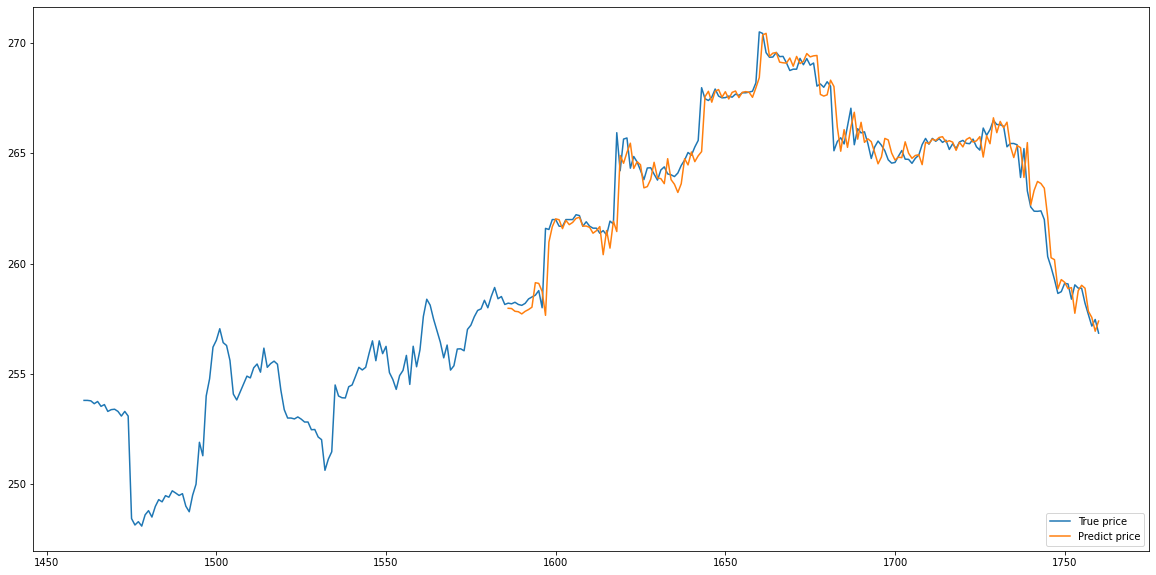

In [134]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
c:\Users\luutr\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


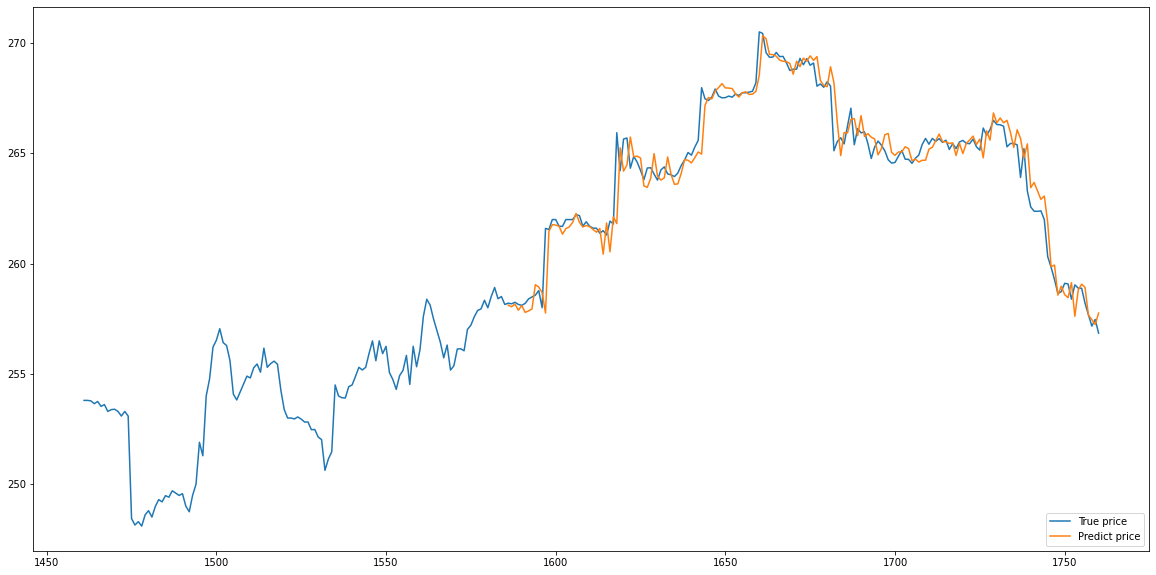

In [135]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

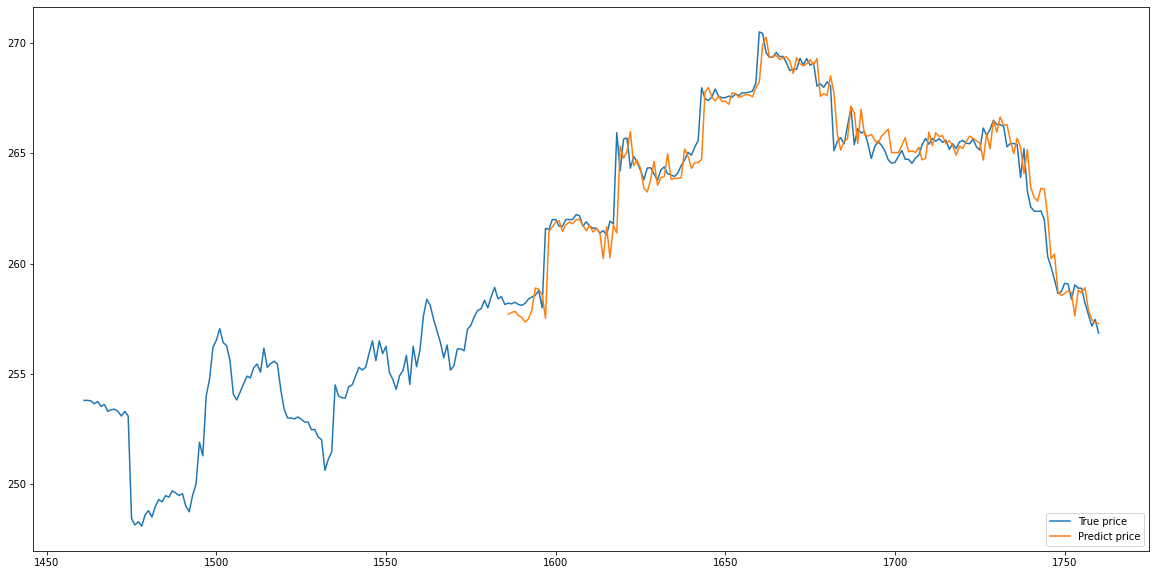

In [136]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

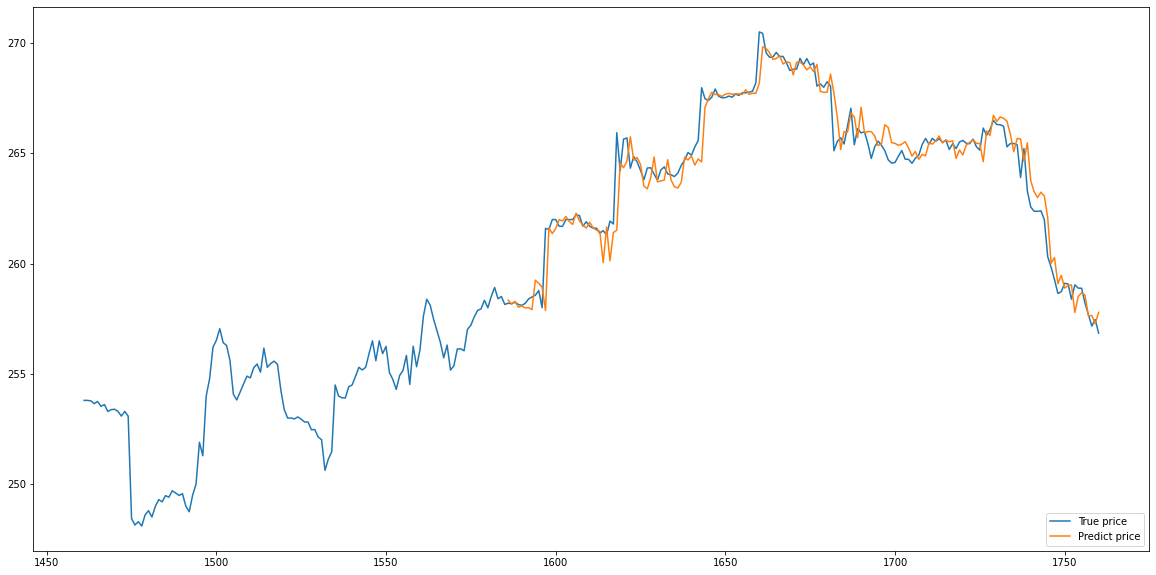

In [137]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

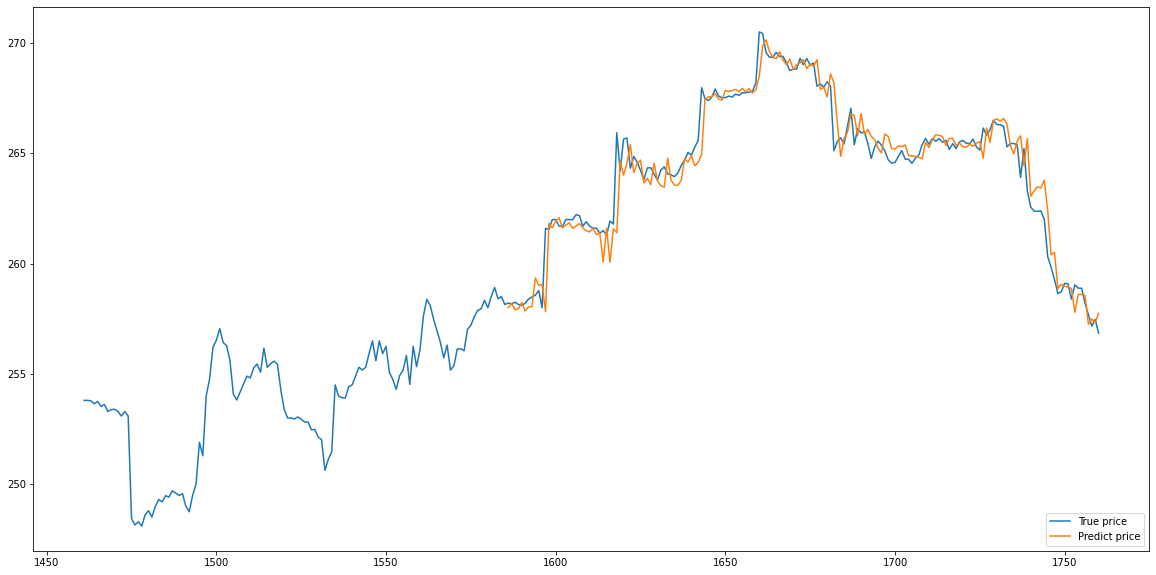

In [138]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

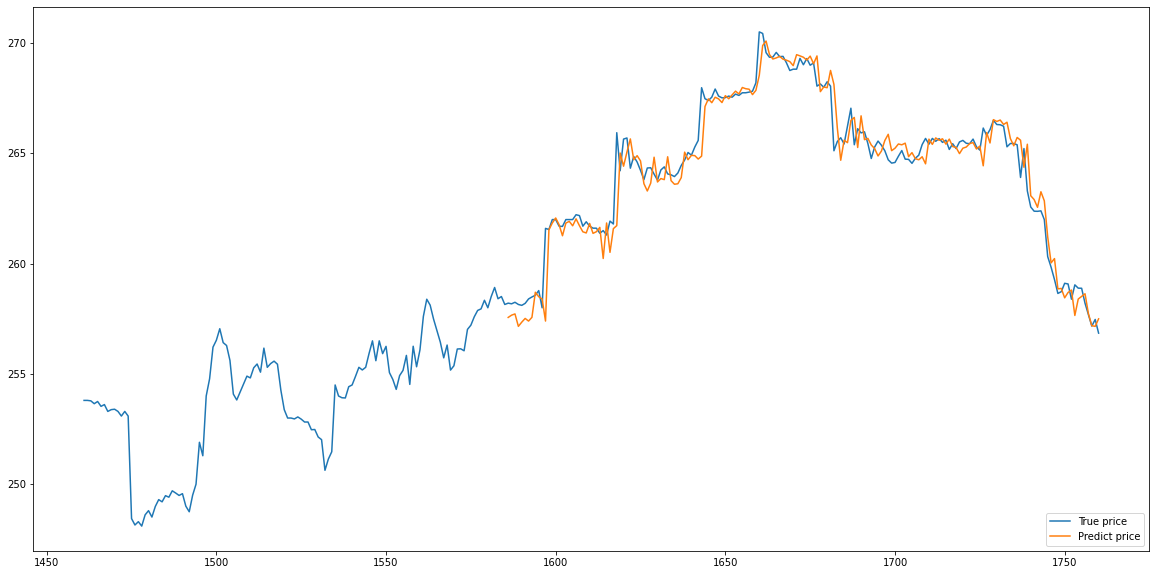

In [139]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

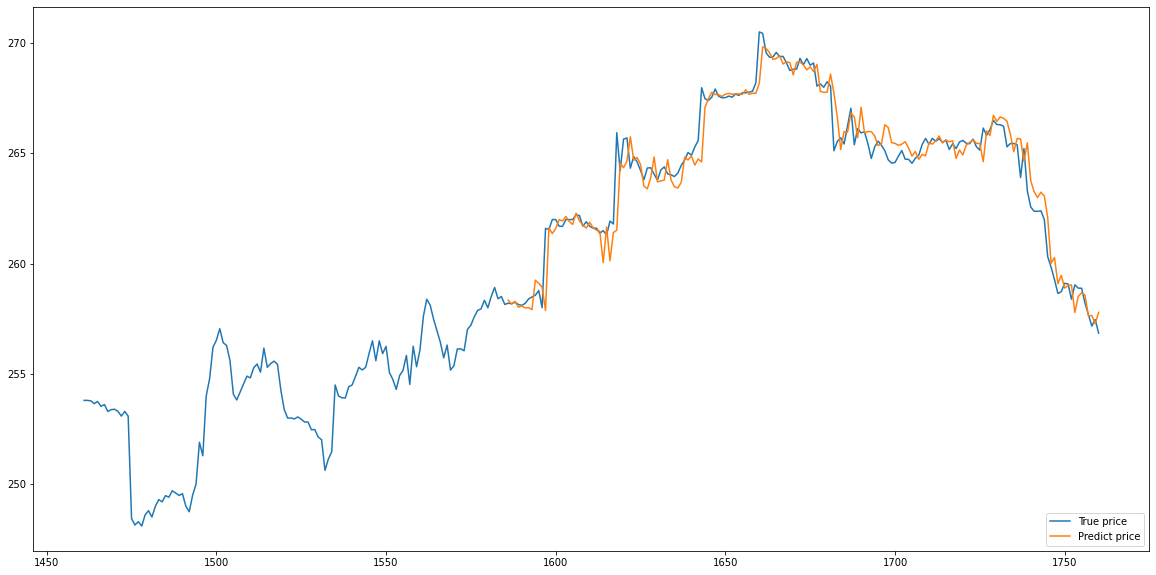

In [140]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

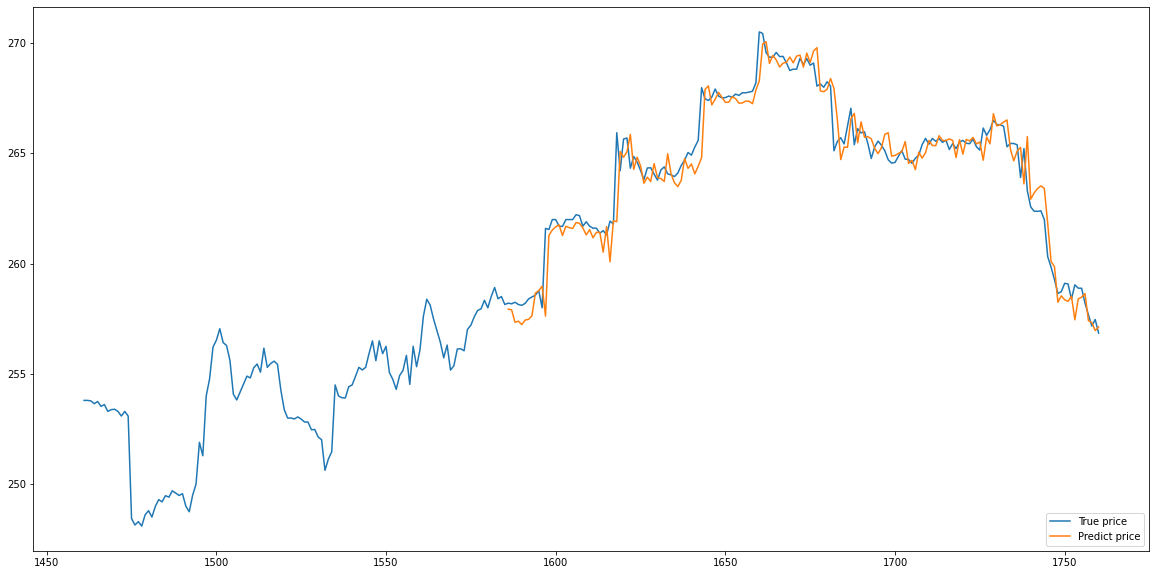

In [141]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

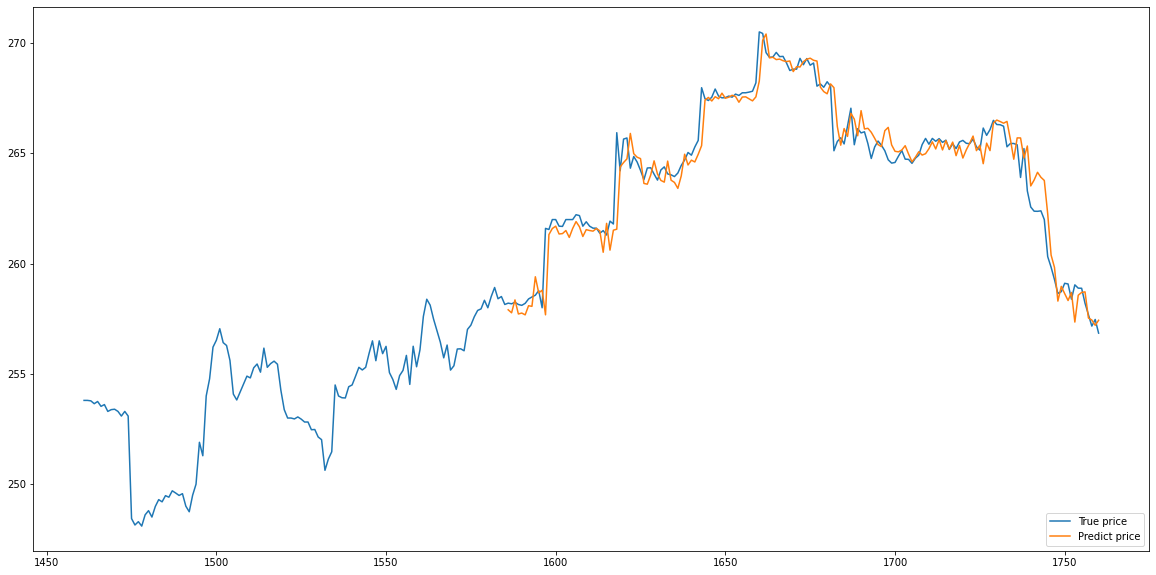

In [142]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

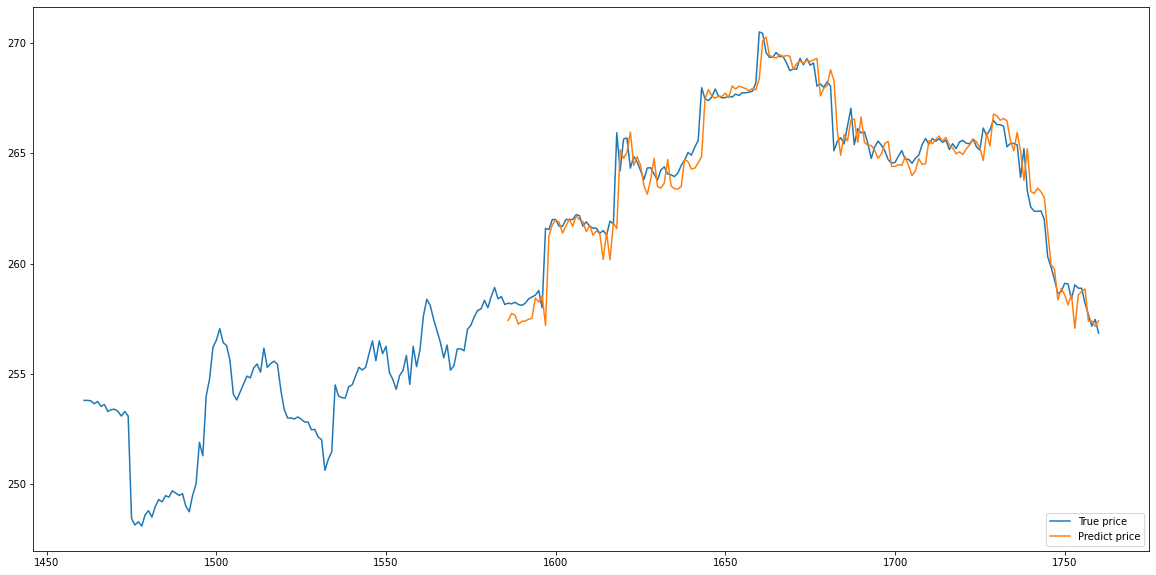

In [143]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

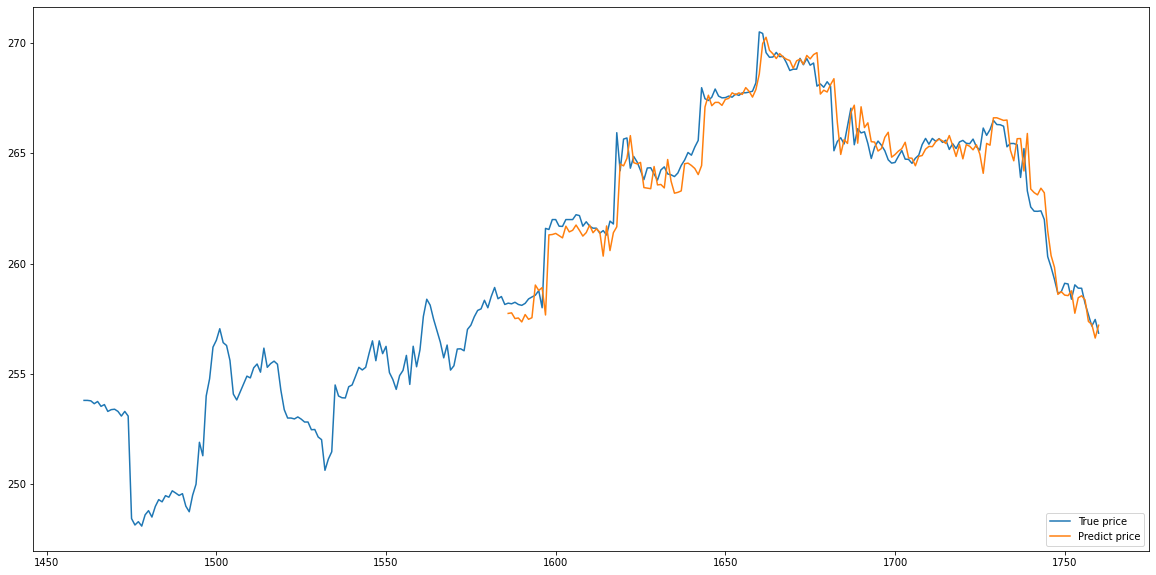

In [144]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

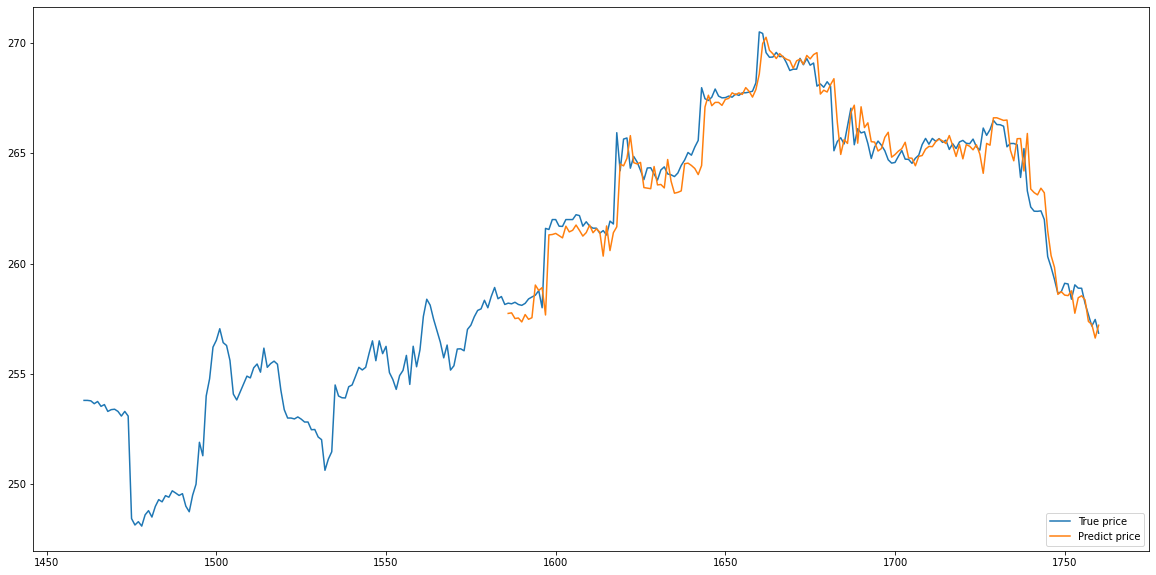

In [145]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

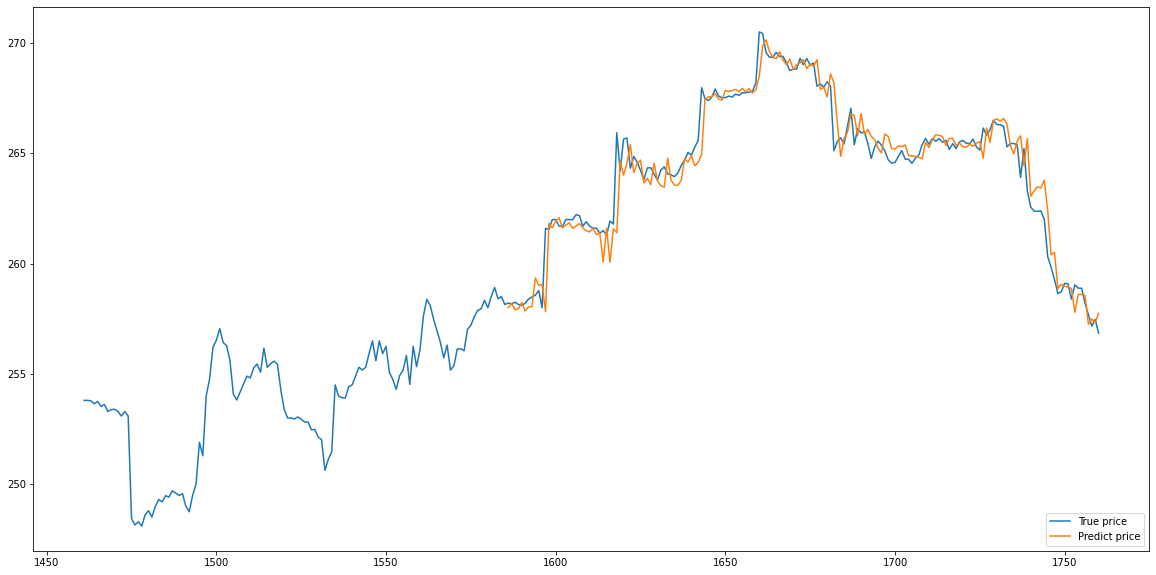

In [146]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

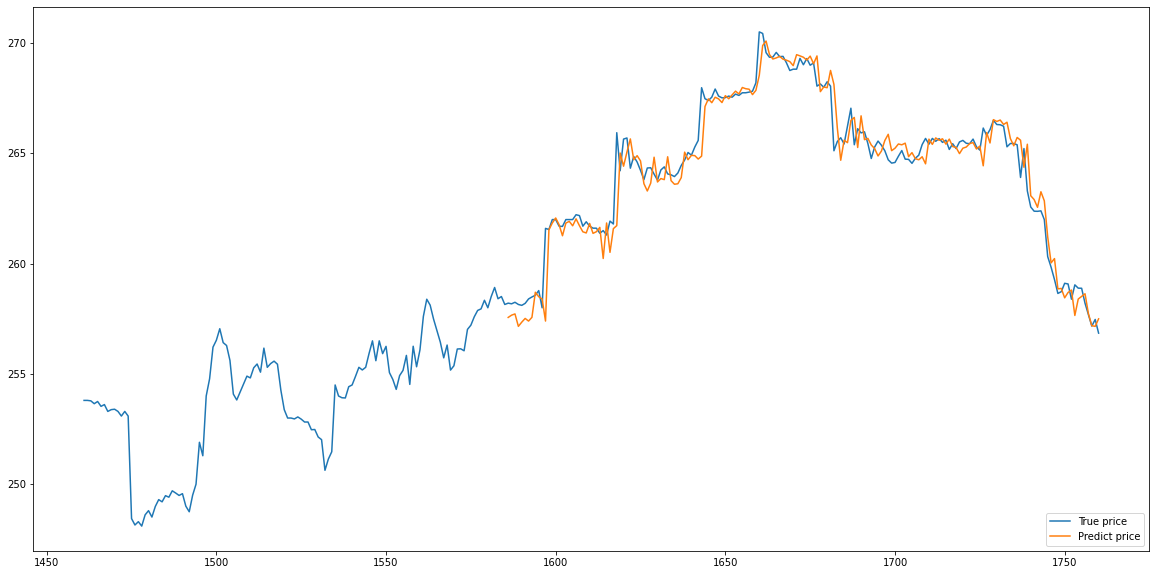

In [147]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

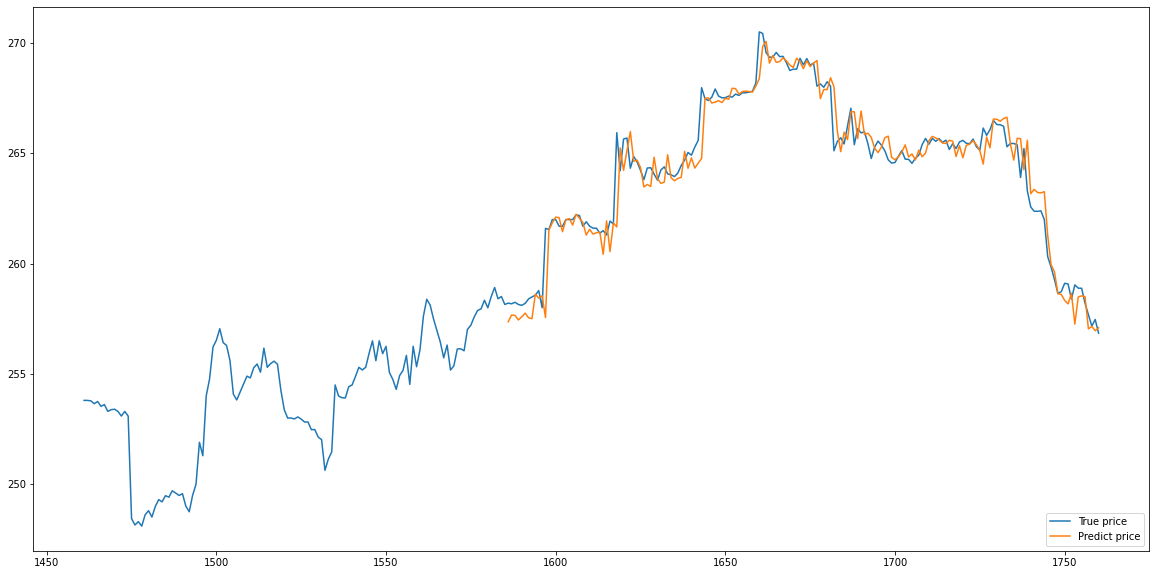

In [148]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

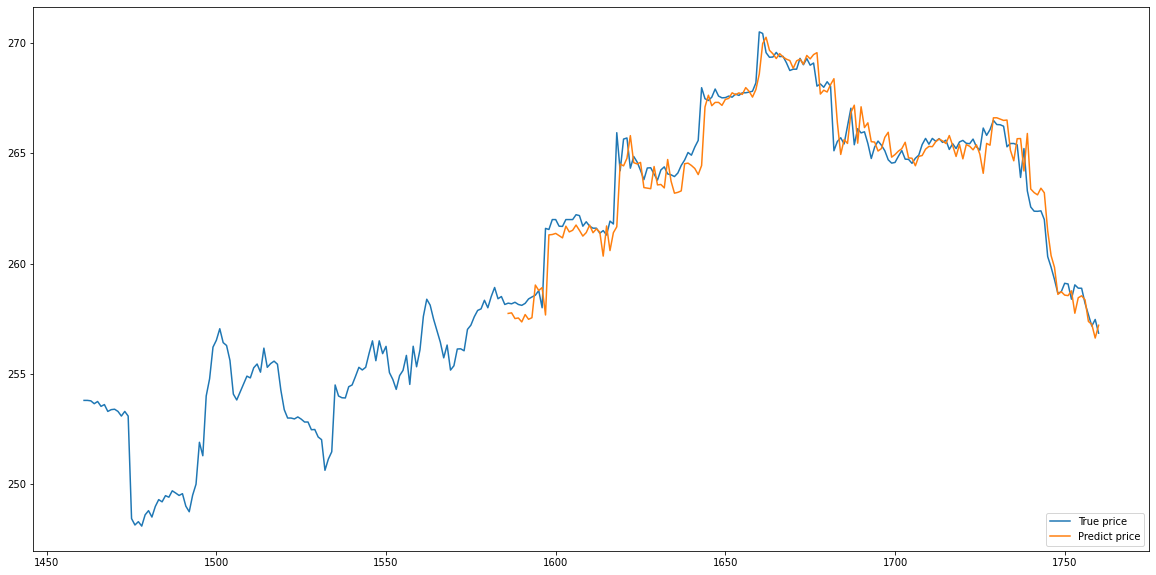

In [149]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [150]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue